2017 Edition

The work presented in this notebook has been done jointly by [Simone Rossi](https://srossi93.github.io/) and [Matteo Romiti](https://github.com/MatteoRomiti)

# Estimating Financial Risk through Monte Carlo Simulation
Risk analysis is part of every decision we make when faced with uncertainty, ambiguity, and variability. Indeed, even though we have unprecedented access to information, we can't accurately predict the future. In finance, there is a fair amount of uncertainty and risk involved with estimating the future value of financial products, due to the wide variety of potential outcomes. Monte Carlo simulation (also known as the Monte Carlo Method) allows inspecting many possible outcomes of the decision making process, and can be used to assess the impact of risk: this, in turns, allows for better decision-making under uncertainty.

## Goals
The main objectives we set for this Notebook are as follows:
1. Develop fundamental knowledge about Risk analysis
2. Understand Monte Carlo Simulation (MCS)
3. Apply Monte Carlo Simulation for predicting risk


## Steps
1. First, in section 1, we introduce the basics of MCS
2. In section 2, we work on a simple example to where we apply the MCS method
3. In section 3, we briefly summarize the main characteristics of the Monte Carlo Simulation (MCS) technique
4. In section 4, we overview the common distributions which are often used in MCS
5. In section 5, we work on a real use case, that focuses on estimating financial risk. We will use techniques such as featurization  (that is, generating additional features to improve model accuracy), linear regression, kernel density estimation, sampling distributions and so on ...

## Reference
This Notebook is inspired by Chapter 9 of the book [Advanced Analytics with Spark](http://shop.oreilly.com/product/0636920035091.do) by Josh Wills, Sandy Ryza, Sean Owen, and Uri Laserson. It is strongly suggested to read this Chapter to get a general idea of the topic of this Notebook.

# 1. Introduction

## 1.1. Monte Carlo Simulation (MCS)
Monte Carlo simulation is a computerized mathematical technique that can be applied such that it is possible to account for risk in quantitative analysis and decision making. This technique is used in many different fields, such as R&D, risk management, portfolio management, pricing derivatives, strategic planning, project planning, cost modeling and many more.

In general, MCS is a technique that "converts" uncertainty on input variables of a model into **probability distributions**. By combining the distributions and randomly selecting values from them, it recalculates the simulated model many times, to determine the probability of the output.

Historically, this technique was first used by scientists working on the atomic bomb: it was named after Monte Carlo, the Monaco resort town renowned for its casinos.  Since its introduction in World War II, Monte Carlo simulation has been used to model a variety of physical and conceptual systems.

## 1.2. How does it work?
Monte Carlo simulation performs risk analysis by building models of possible results by *substituting a range of possible input values, that constitute uncertainty, into a statistical distribution*. It then computes possible outcomes repeatedly, each time using a different set of random values from the probability functions that "model" the input. Depending upon the number of random input variables and their distribution, a Monte Carlo simulation could involve thousands or tens of thousands of "rounds" before it is complete. When complete, *Monte Carlo simulation produces distributions of possible outcome values*.

By using probability distributions instead of actual input samples, it is possible to model more accurately uncertainty: different choices of distributions will yield different outputs.

# 2. Illustrative example

Imagine you are the marketing manager for a firm that is planning to introduce a new product. You need to estimate the first-year net profit from this product, which might depend on:

- Sales volume in units
- Price per unit (also called "Selling price")
- Unit cost
- Fixed costs

Net profit will be calculated as $Net Profit = Sales Volume* (Selling Price - Unit cost) - Fixed costs$.  Fixed costs (accounting for various overheads, advertising budget, etc.) are known to be \$ 120,000, which we assume to be deterministic. All other factors, instead, involve some uncertainty: *sales volume* (in units) can cover quite a large range, the *selling price* per unit will depend on competitor actions, which are hard to predict, and *unit costs* will also vary depending on vendor prices and production experience, for example.

Now, to build a risk analysis model, we must first identify the uncertain variables -- which are essentially random variables.  While there's some uncertainty in almost all variables in a business model, we want to focus on variables where the range of values is significant.

## 2.1. Unit sales and unit price

Based on a hypothetical market research you have done, you have beliefs that there are equal chances for the market to be `slow`, `normal`, or `hot`:

- In a "slow" market, you expect to sell 50,000 units at an average selling price of \$11.00 per unit
- In a "normal" market, you expect to sell 75,000 units, but you'll likely realize a lower average selling price of \$10.00 per unit
- In a "hot" market, you expect to sell 100,000 units, but this will bring in competitors, who will drive down the average selling price to \$8.00 per unit

In [1]:
import scipy
import random
import math

import numpy             as np
import statsmodels.api   as sm
import seaborn           as sns
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
#import plotly.plotly     as py
#import plotly.graph_objs as go
#import pandas_datareader.data as web

from statsmodels.nonparametric.kernel_density import KDEMultivariate
from statsmodels.nonparametric.kde            import KDEUnivariate

from sklearn.mixture import GMM#, BayesianGaussianMixture
from sklearn         import preprocessing

from scipy.stats import entropy
from scipy.stats import chisqprob, chi2
from scipy import stats

from datetime import datetime
from time     import time
from datetime import datetime
from datetime import timedelta

from itertools import islice
from pprint    import pprint
from os        import listdir
from os.path   import isfile, join

%matplotlib inline

base_folder = "monte-carlo-risk/"
factors_folder= base_folder + "factors/"
stock_folder = base_folder + 'stocks'

/opt/conda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


### Question 1
<div class="alert alert-info">
Calculate the average units and the unit price that you expect to sell, which depend on the market state. Use the assumptions above to compute the expected quantity of products and their expected unit price. 
</div>


In [2]:
average_unit = (50000 + 75000 + 100000) / 3
average_price = (11 + 10 + 8) / 3
print("average unit: %d" % average_unit) 
print("average_price: %.2f" % average_price) # typo

average unit: 75000
average_price: 9.67


## 2.2. Unit Cost

Another uncertain variable is Unit Cost. In our illustrative example, we assume that your firm's production manager advises you that unit costs may be anywhere from \$5.50 to \$7.50, with a most likely expected cost of \$6.50. In this case, the most likely cost can be considered as the average cost.

## 2.3. A Flawed Model: using averages to represent our random variables
Our next step is to identify uncertain functions -- also called functions of a random variable.  Recall that Net Profit is calculated as $Net Profit = Sales Volume * (Selling Price - Unit cost) - Fixed costs$.  However, Sales Volume, Selling Price and Unit Cost are all uncertain variables, so Net Profit is an uncertain function.

The simplest model to predict the Net Profit is using average of sales volume, average of selling price and average of unit cost for calculating. So, if only consider averages, we can say that the $Net Profit = 75,000*(9.66666666 - 6.5) - 120,000 \sim 117,500$.

However, as [Dr. Sam Savage](http://web.stanford.edu/~savage/faculty/savage/) warns, "Plans based on average assumptions will be wrong on average." The calculated result is far from the actual value: indeed, the **true average Net Profit** is roughly  \$93,000, as we will see later in the example.

### Question 2
#### Question 2.1
<div class="alert alert-info">
Write a function named `calNetProfit` to calculate the Net Profit using the average of sales volume, the average of selling price and the average of unit cost.
</div>

In [118]:
def calNetProfit(average_unit, average_price, \
                 average_unitcost, fixed_cost):
    return average_unit*(average_price - average_unitcost) -fixed_cost

average_unitcost = 6.5
fixed_cost = 120000
NetProfit = calNetProfit(average_unit, average_price, \
                         average_unitcost, fixed_cost)
print("Net profit: %.2f" % NetProfit)

Net profit: 117500.00


#### Question 2.2
<div class="alert alert-info">
Verify the warning message of Dr. Sam Savage by calculating the error of our estimated Net Profit using averages only. Recall that the true value is roughly \$93,000, so we are interested in:
<ul></ul>

$$ error = \frac{your\_value - true\_value}{true\_value}$$

<ul></ul>
Note also we are interested in displaying the error as a percentage.
<ul></ul>
Looking at the error we make, do you think that we can use the current model that only relies on averages?
</div>

In [119]:
trueNetProfit = 93000
error = (NetProfit - trueNetProfit) / (trueNetProfit)
print("Error in percentage: %.2f" % (error * 100))

Error in percentage: 26.34


<div class="alert alert-success">
We definitely cannot use this model to estimate net profits. It will provide us unreliable and wrong information. Using average value to find profit is incorrect.
</div>

## 2.4. Using the Monte Carlo Simulation method to improve our model
As discussed before, the selling price and selling volume both depend on the state of the market scenario (slow/normal/hot). So, the net profit is the result of two random variables: `market scenario` (which in turn determines `sales volumes` and `selling price`) and `unit cost`.

Now, let's assume (this is an *a-priori* assumption we make) that `market scenario` follows a discrete, uniform distribution and that `unit cost` also follows a uniform distribution. Then, we can compute directly the values for selling price and selling volumes based on the outcome of the random variable `market scenario`, as shown in Section 2.1.

From these a-priori distributions, in each run (or trial) of our Monte Carlo simulation, we can generate the sample value for each random variable and use it to calculate the Net Profit. The more simulation runs, the more accurate our results will be. For example, if we run the simulation 100,000 times, the average net profit will amount to roughly \$92,600. Every time we run the simulation, a different prediction will be output: the average of such predictions will consistently be less than \$117,500, which we predicted using averages only.

Note also that in this simple example, we generate values for the `market scenario` and `unit cost` independently: we consider them to be **independent random variables**. This means that the eventual (and realistic!) correlation between the `market scenario` and `unit cost` variables is ignored. Later, we will learn how to be more precise and account for dependency between random variables.


### Question 3
#### Question 3.1
<div class="alert alert-info">
Write a function named `get_sales_volume_price` that returns the sales volume and price based on the market scenario. In particular, the scenario can get one of three values:
<ul>
  <li>0: Slow market</li>
  <li>1: Normal market</li>
  <li>2: Hot market</li>
</ul>  

The return value is a tuple in the form: `(sales_volume, price)`
</div>

In [120]:
# Get sales volume and  price based on market scenario
# the function returns a tuple of (sales_volume, price)
def get_sales_volume_price(scenario):
    # Slow market
    if scenario == 0:
        return (50000, 11.0)
    # Normal market
    if scenario == 1:
        return (75000, 10.0)
    # Hot market
    if scenario == 2:
        return (100000, 8.0)

#### Question 3.2
<div class="alert alert-info">
Run 100,000 Monte Carlo simulations and calculate the average net profit they produce. Then, compare the result to the "average model" we used in the previous questions (the one we called "flawed" model). Put your comments about the discrepancies between a simplistic model, and the more accurate MCS approach.  
<ul></ul>
Note that in each iteration, the `unit_cost` and `market_scenario` are generated according to their distributions. Also, recall what we have seen in Section 2.2: your firm account manager helped you with some research, to determine the variability of your random variables.  
</div>


<div class="label label-success">HINT</div>  

Function `uniform(a,b)` in module `random` generates a number $a<=c<=b$, which is drawn from a uniform distribution.  

Function `randint(a,b)` helps you generating an integer number $a<=c<=b$

In [126]:
import random

fixed_cost = 120000
total = 0.0
num_simulations = range(100, 100000, 100)
ev = []
for num_simulation in num_simulations:
    #print(num_simulation, ' ', end='')
    t0 = time()
    total = 0.0
    for i in range(num_simulation):
        unit_cost = random.uniform(5.5, 7.5)
        market_scenario = random.randint(0,2)
        sales_volume, price = get_sales_volume_price(market_scenario)
        netProfit = calNetProfit(sales_volume, price, unit_cost, fixed_cost)
        total += netProfit
    t1 = time()
    MCS_net_profit = total / num_simulation
    ev.append((MCS_net_profit, (100*abs(MCS_net_profit-trueNetProfit) / trueNetProfit), \
               t1-t0, num_simulation))

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


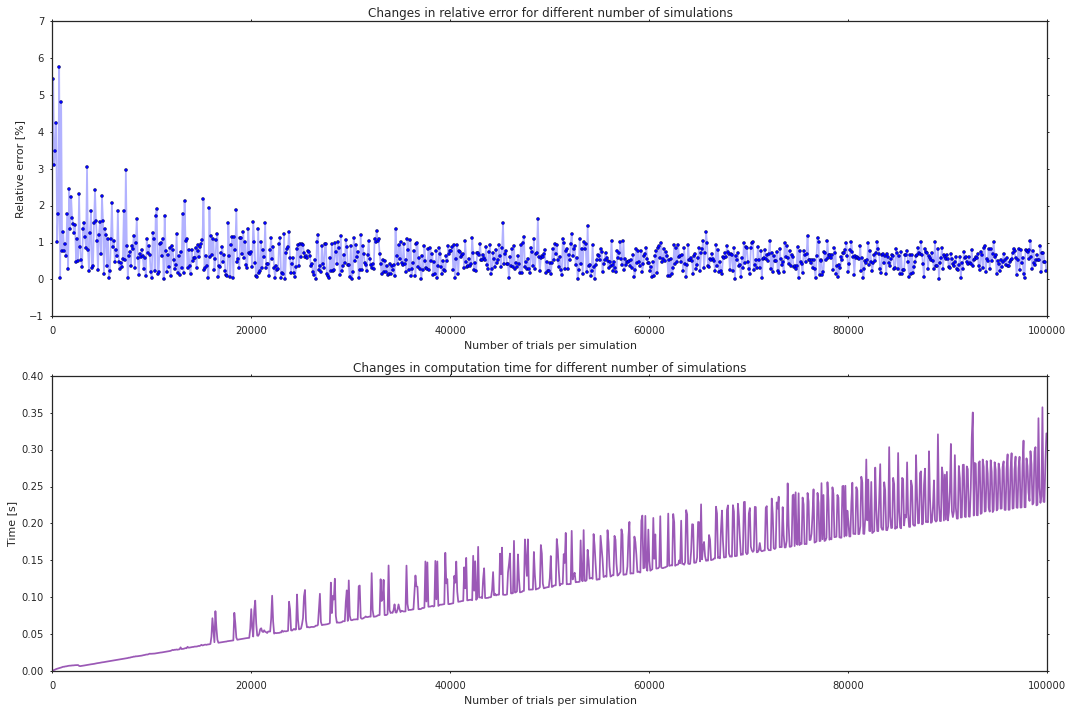

In [168]:
evaluations_df = pd.DataFrame(ev, columns=['avg', 'err', 'time', 'iter'])
plt.figure(figsize=[15, 10])

plt.subplot(211)
ax = plt.gca()
ax.set_xlim(0, 100000)
plt.title('Changes in relative error for different number of simulations')
plt.scatter(x=evaluations_df['iter'], y=evaluations_df['err'], s=10)
plt.xlabel('Number of trials per simulation')
plt.ylabel('Relative error [%]')
ax.plot(evaluations_df['iter'], evaluations_df['err'], color='b', alpha=0.3)


plt.subplot(212)
plt.title('Changes in computation time for different number of simulations')
plt.plot(evaluations_df['iter'], evaluations_df['time'],)
plt.xlabel('Number of trials per simulation')
plt.ylabel('Time [s]')


plt.tight_layout()

<div class="alert alert-success">
We wanted to investigate a little bit more in detail on how the Monte Carlo Simulation works to be prepared for the real use-case.
<br><br>
Using Monte Carlo Simulation we get a different and more accurate net profit value. The relative error has now an acceptable value. Nevetheless, it does not converge to zero even though the number of trials increased. This gives us an 'empirical' bound on this parameter for the following analisys. We can also retrieve some useful timing information from these simulations: for instance we plotted the computational time against the number of simulations and despite a linear baseline, we find some unusual peaks, maybe due to memory/cache misalignments.
</div>


# 3. A brief summary of the Monte Carlo Simulation (MCS) technique

- A MCS allows several inputs to be used at the same time to compute the probability distribution of one or more outputs
- Different types of probability distributions can be assigned to the inputs of the model, depending on any *a-priori* information that is available. When the distribution is completely unknown, a common technique is to use a distribution computed by finding the best fit to the data you have
- The MCS method is also called a **stochastic method** because it uses random variables. Note also that the general assumption is for input random variables to be independent from each other. When this is not the case, there are techniques to account for correlation between random variables.
- A MCS generates the output as a range instead of a fixed value and shows how likely the output value is to occur in that range. In other words, the model outputs a probability distribution.

# 4. Common distributions used in MCS
In what follows, we summarize the most common probability distributions that are used as *a-priori* distributions for input random variables:

- *Normal/Gaussian Distribution*: this is a continuous distribution applied in situations where the mean and the standard deviation of a given input variable are given, and the mean represents the most probable value of the variable. In other words, values "near" the mean are most likely to occur.  This is symmetric distribution, and it is not bounded in its co-domain. It is very often used to  describe natural phenomena, such as people’s heights, inflation rates, energy prices, and so on and so forth. An illustration of a normal distribution is given below:
![normal_distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Normal_Distribution_PDF.svg/320px-Normal_Distribution_PDF.svg.png)

- *Lognormal Distribution*: this is a distribution which is appropriate for variables taking values in the range $[0, \infty]$. Values are positively skewed, not symmetric like a normal distribution.  Examples of variables described by some lognormal distributions include, for example, real estate property values, stock prices, and oil reserves. An illustration of a lognormal distribution is given below:
![log_normal_distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/PDF-log_normal_distributions.svg/320px-PDF-log_normal_distributions.svg.png) 

- *Triangular Distribution*: this is a continuous distribution with fixed minimum and maximum values. It is bounded by the minimum and maximum values and can be either symmetrical (the most probable value = mean = median) or asymmetrical. Values around the most likely value (e.g. the mean) are more likely to occur.  Variables that could be described by a triangular distribution include, for example, past sales history per unit of time and inventory levels. An illustration of a triangular distribution is given below:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Triangular_distribution_PMF.png/320px-Triangular_distribution_PMF.png)

- *Uniform Distribution*: this is a continuous distribution bounded by known minimum and maximum values. In contrast to the triangular distribution, the likelihood of occurrence of the values between the minimum and maximum is the same. In other words, all values have an equal chance of occurring, and the distribution is simply characterized by the minimum and maximum values. Examples of variables that can be described by a uniform distribution include manufacturing costs or future sales revenues for a new product. An illustration of the uniform distribution is given below:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Uniform_Distribution_PDF_SVG.svg/320px-Uniform_Distribution_PDF_SVG.svg.png)

- *Exponential Distribution*: this is a continuous distribution used to model the time that pass between independent occurrences, provided that the rate of occurrences is known. An example of the exponential distribution is given below:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Exponential_pdf.svg/320px-Exponential_pdf.svg.png)

- *Discrete Distribution* : for this kind of distribution, the "user" defines specific values that may occur and the likelihood of each of them.  An example might be the results of a lawsuit: 20% chance of positive verdict, 30% change of negative verdict, 40% chance of settlement, and 10% chance of mistrial.


# 5. A real use case: estimating the financial risk of a portfolio of stocks
We hope that by now you have a good understanding about Monte Carlo simulation. Next, we apply this method to a real use case: *financial risk estimation*.

Imagine that you are an investor on the stock market. You plan to buy some stocks and you want to estimate the maximum loss you could incur after two weeks of investing. This is the quantity that the financial statistic "Value at Risk" (VaR) seeks to measure. [VaR](https://en.wikipedia.org/wiki/Value_at_risk) is defined as a measure of investment risk that can be used as a reasonable estimate of the maximum probable loss for a value of an investment portfolio, over a particular time period. A VaR statistic depends on three parameters: a portfolio, a time period, and a confidence level. A VaR of 1 million dollars with a 95% confidence level over two weeks, indicates the belief that the portfolio stands only a 5% chance of losing more than 1 million dollars over two weeks. VaR has seen widespread use across financial services organizations. This statistic plays a vital role in determining how much cash investors must hold to meet the credit ratings that they seek. In addition, it is also used to understand the risk characteristics of large portfolios: it is a good idea to compute the VaR before executing trades, such that it can help take informed decisions about investments. 

Our goal is calculating VaR of two weeks interval with 95% confidence level and the associated [VaR confidence interval](http://www.investopedia.com/ask/answers/041615/whats-difference-between-confidence-level-and-confidence-interval-value-risk-var.asp).


## 5.1. Terminology
In this use case, we will use some terms that might require a proper definition, given the domain. This is what we call the *Domain Knowledge*.

- **Instrument**: A tradable asset, such as a bond, loan, option, or stock investment. At any particular time, an instrument is considered to have a value, which is the price for which it can be sold. In the use case of this notebook, instruments are stock investments.
- **Portfolio**: A collection of instruments owned by a financial institution. 
- **Return**: The change in an instrument or portfolio’s value over a time period. 
- **Loss**: A negative return. 
- **Index**: An imaginary portfolio of instruments. For example, the NASDAQ Composite index includes about 3,000 stocks and similar instruments for major US and international companies. 
- **Market factor**: A value that can be used as an indicator of macro aspects of the financial climate at a particular time. For example, the value of an index, the Gross Domestic Product of the United States, or the exchange rate between the dollar and the euro. We will often refer to market factors as just factors.

## 5.2. The context of our use case
We have a list of instruments that we plan to invest in. The historical data of each instrument has been collected for you. For simplicity, assume that the returns of instruments at a given time, depend on 4 market factors only: 

- GSPC value
- IXIC value 
- The return of crude oil
- The return of treasury bonds

Our goal is building a model to predict the loss after two weeks' time interval with confidence level set to 95%.

As a side note, it is important to realize that the approach presented in this Notebook is a simplified version of what would happen in a real Financial firm. For example, the returns of instruments at a given time often depend on more than 4 market factors only! Moreover, the choice of what constitute an appropriate market factor is an art!



## 5.3. The Data
The stock data can be downloaded (or scraped) from Yahoo! by making a series of REST calls. The data includes multiple files. Each file contains the historical information of each instrument that we want to invest in. The data is in the following format (with some samples):
```
Date, Open, High, Low, Close, Volume, Adj Close
2016-01-22,66.239998,68.07,65.449997,67.860001,137400,67.860001
2016-01-21,65.410004,66.18,64.459999,65.050003,148000,65.050003
2016-01-20,64.279999,66.32,62.77,65.389999,141300,65.389999
2016-01-19,67.720001,67.989998,64.720001,65.379997,178400,65.379997
```

The data of GSPC and IXIC values (our two first market factors) are also available on Yahoo! and use the very same format. 

The crude oil and treasure bonds data is collected from investing.com, and has a different format, as shown below (with some samples):
```
Date    Price   Open    High    Low     Vol.    Change %
Jan 25, 2016    32.17   32.36   32.44   32.10   -       -0.59%
Jan 24, 2016    32.37   32.10   32.62   31.99   -       0.54%
Jan 22, 2016    32.19   29.84   32.35   29.53   -       9.01%
Jan 21, 2016    29.53   28.35   30.25   27.87   694.04K 11.22%
Jan 20, 2016    26.55   28.33   28.58   26.19   32.11K  -6.71%
Jan 19, 2016    28.46   29.20   30.21   28.21   188.03K -5.21%
```

In our use case, the factors' data will be used jointly to build a statistical model: as a consequence, we first need to preprocess the data to proceed.

## 5.4. Data preprocessing
In this Notebook, all data files have been downloaded for you, such that you can focus on pre-processing. Next, we will:

  - Read the factor data files which are in two different formats, process and merge them together
  - Read the stock data and pre-process it
  - Trim all data into a specific time region
  - Fill in the missing values
  - Generate the data of returns in each two weeks' time interval window
  
### Factor data pre-processing

We need two functions to read and parse data from Yahoo! and Investing.com respectively. We are interested only in information about the time and the corresponding returns of a factor or an instrument: as a consequence, we will project away many columns of our RAW data, and keep only the information we are interested in.

The 3000-instrument and the 4-factor history are small enough to be read and processed locally: we do not need to use the power of parallel computing to proceed. Note that this is true also for larger cases with hundreds of thousands of instruments and thousands of factors. The need for a distributed system like Spark comes in when actually **running** the Monte Carlo simulations, which can require massive amounts of computation on each instrument. 

### Question 4
#### Question 4.1
<div class="alert alert-info">
Write a function named `readInvestingDotComHistory` to parse data from investing.com based on the format specified above (see Section 5.3). Recall that we use two factors here: one that is related to the price of crude oil, one that is related to some specific US bonds. 

<ul></ul>

Print the first 5 entries of the first factor (crude oil price) in the parsed data.

<ul></ul>

Note that we are only interested in the date and price of stocks.

</div>

<div class="label label-success">HINT</div>  
You can parse a string to `datetime` object by using the function `strptime(<string>, <dtime_format>)`. In this case, the datetime format is `"%b %d, %Y"`. For more information, please follow this [link](https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior).

In the next cell, we simply copy data from our HDFS cluster (that contains everything we need for this Notebook) to the instance (a Docker container) running your Notebook. This means that you will have "local" data that you can process without using Spark. Note the folder location: find and verify that you have correctly downloaded the files!

In [8]:
! [ -d monte-carlo-risk ] || (echo "Downloading prepared data from HDFS. Please wait..." ; \
                              hdfs dfs -copyToLocal /datasets/monte-carlo-risk . ; echo "Done!";)

In [3]:
# read data from local disk
def readInvestingDotComHistory(fname):
    def process_line(line):
        cols = line.split('\t')
        date = datetime.strptime(cols[0], "%b %d, %Y")
        value = float(cols[1])
        return (date, value)
    
    with open(fname) as f:
        content_w_header = f.readlines()
        # remove the first line 
        # and reverse lines to sort the data by date, in ascending order
        content = content_w_header[1: len(content_w_header)]
        data = list(map(process_line , content))
        data.sort(key=lambda x:x[0])
        return data

factor1_files = ['crudeoil.tsv', 'us30yeartreasurybonds.tsv']
factor1_files = map(lambda fn: factors_folder + fn, factor1_files)
factors1 = [readInvestingDotComHistory(f) for f in factor1_files]

pprint(factors1[0][:5])

pprint(factors1[1][:5])

[(datetime.datetime(2006, 1, 26, 0, 0), 66.26),
 (datetime.datetime(2006, 1, 27, 0, 0), 67.76),
 (datetime.datetime(2006, 1, 30, 0, 0), 68.35),
 (datetime.datetime(2006, 1, 31, 0, 0), 67.92),
 (datetime.datetime(2006, 2, 1, 0, 0), 66.56)]
[(datetime.datetime(2008, 2, 12, 0, 0), 4.457),
 (datetime.datetime(2008, 2, 13, 0, 0), 4.54),
 (datetime.datetime(2008, 2, 14, 0, 0), 4.654),
 (datetime.datetime(2008, 2, 15, 0, 0), 4.582),
 (datetime.datetime(2008, 2, 19, 0, 0), 4.665)]


Now, the data structure `factors1` is a list, containing data that pertains to two (out of a total of four) factors that influence the market, as obtained by investing.com. Each element in the list is a tuple, containing some sort of timestamp, and the value of one of the two factors discussed above. From now on, we call these elements "**records**" or "**entries**". Visually, `factors1` looks like this:

| 0 (crude oil) | 1 (US bonds)|
| --- | --- |
| time_stamp, value | time_stamp, value |
| ... | ... |
| time_stamp, value | time_stamp, value |
| ... | ... |


In [149]:
df0 = pd.DataFrame(factors1[0], columns=['Date','CrudeOil'])
df1 = pd.DataFrame(factors1[1], columns=['Date','USbonds'])
tmp = df0.merge(df1, on=['Date'], how='outer')
tmp = tmp.set_index('Date')
tmp.index = tmp.index.to_datetime()
print(tmp.describe())

          CrudeOil      USbonds
count  2544.000000  2155.000000
mean     80.596808     3.587612
std      21.455740     0.660748
min      26.550000     2.223000
25%      63.815000     3.011500
50%      82.535000     3.524000
75%      96.910000     4.227000
max     145.290000     4.834000


<div class="alert alert-success">
Some statistics about the crude oil (WTI) price from 2006 to 2016: on average we paid \$80.60 per barrel, the lowest price was \$26.55 while the highest was \$145.29, a big difference!
For a European citizen, an additional information would be needed to have a more precise idea, i.e. the US Dollar-Euro exchange rate.   
The 30-year US Treasury Bond, also called long bond because it is the bond with the longest maturity issued by the US Treasury, is the most actively traded bond in the world. Since it is backed by the US Treasury and has a low default risk, the long bond is considered one of the safest securities around, but its longer maturity also makes it more vulnerable to rising interest rates than treasuries with shorter maturities.
On average it has an interest rate of 3.59%, a lowest of 2.22% and a highest of 4.83%. We will discuss more about these numbers later in the notebook.


</div>

#### Question 4.2
<div class="alert alert-info">
Write a function named `readYahooHistory` to parse data from yahoo.com based on its format, as described in Section 5.3.  
<ul></ul>
Print the first 5 entries of the first factor (namely GSPC). Comment the time range of the second batch of data we use in our Notebook.  
<ul></ul>

Note that we are only interested in the date and price of stocks.
</div>

<div class="label label-danger">NOTE</div> The datetime format now is in a different format than the previous one.

<div class="label label-success">HINT</div> Use a terminal (or put the bash commands inline in your Notebook) to list filenames in your local working directory to find and have a look at your local files.

In [4]:
# read data from local disk
def readYahooHistory(fname):
    def process_line(line):
        cols = line.split(',')
        date = datetime.strptime(cols[0], "%Y-%m-%d")
        value = float(cols[4])#Close price
        return (date, value)
    
    with open(fname) as f:
        content_w_header = f.readlines()
        # remove the first line 
        # and reverse lines to sort the data by date, in ascending order
        content = content_w_header[1: len(content_w_header)]
        data = list(map(process_line , content))
        data.sort(key=lambda x:x[0])
        return data
    

factor2_files = ['GSPC.csv', 'IXIC.csv']
factor2_files = map(lambda fn: factors_folder + fn, factor2_files)

factors2 = [readYahooHistory(f) for f in factor2_files]

pprint(factors2[0][:5])

pprint(factors2[1][:5])

[(datetime.datetime(1950, 1, 3, 0, 0), 16.66),
 (datetime.datetime(1950, 1, 4, 0, 0), 16.85),
 (datetime.datetime(1950, 1, 5, 0, 0), 16.93),
 (datetime.datetime(1950, 1, 6, 0, 0), 16.98),
 (datetime.datetime(1950, 1, 9, 0, 0), 17.08)]
[(datetime.datetime(1971, 2, 5, 0, 0), 100.0),
 (datetime.datetime(1971, 2, 8, 0, 0), 100.839996),
 (datetime.datetime(1971, 2, 9, 0, 0), 100.760002),
 (datetime.datetime(1971, 2, 10, 0, 0), 100.690002),
 (datetime.datetime(1971, 2, 11, 0, 0), 101.449997)]


<div class="alert alert-success">
For these two last factors (GSPC and IXIC) we have available data since 1950 and 1971. On the other hand, US bonds and Crude Oil have been collected only on last 8 years (from 2008 and 2007 respectively). 
<br><br>
To have meaningful data, we use only the closing price on a working day (5th field of a record), dropping all the others information. Though, it might be also useful to investigate variations of the price during a day.
</div>

Now, the data structure `factors2` is again list, containing data that pertains to the next two (out of a total of four) factors that influence the market, as obtained by Yahoo!. Each element in the list is a tuple, containing some sort of timestamp, and the value of one of the two factors discussed above. Visually, `factors2` looks like this:

| 0 (GSPC) | 1 (IXIC)|
| --- | --- |
| time_stamp, value | time_stamp, value |
| ... | ... |
| time_stamp, value | time_stamp, value |
| ... | ... |


In [151]:
df0 = pd.DataFrame(factors2[0], columns=['Date','GSPC'])
df1 = pd.DataFrame(factors2[1], columns=['Date','IXIC'])
tmp = df0.merge(df1, on=['Date'], how='outer')
tmp = tmp.set_index('Date')
tmp.index = tmp.index.to_datetime()
print(tmp.describe())

               GSPC          IXIC
count  16621.000000  11340.000000
mean     485.507115   1288.236828
std      558.308433   1290.428163
min       16.660000     54.869999
25%       83.910004    204.992504
50%      146.690002    704.565002
75%      955.250000   2154.625000
max     2130.820068   5218.859863


<div class="alert alert-success">
GSPC, also known as the S&P 500, is an American stock market index based on the market capitalizations of 500 large companies having common stock listed on the NYSE or NASDAQ. It covers about 80 percent of the American equity market by capitalization.
The NASDAQ Composite, IXIC, is a stock market index of the common stocks (4,000+) listed on the NASDAQ stock market. The composition of the NASDAQ Composite is heavily weighted towards information technology companies.
Both indexes reached very low values in history, but the second one has a higher average, minimum and maximum values.
</div>

<div class="alert alert-success">
<h1>Let's visualize and analyze our factors!</h1>
</div>

In [27]:
df0 = pd.DataFrame(factors1[0], columns=['Date','CrudeOil'])
df1 = pd.DataFrame(factors1[1], columns=['Date','USbonds'])
df2 = pd.DataFrame(factors2[0], columns=['Date','GSPC'])
df3 = pd.DataFrame(factors2[1], columns=['Date','IXIC'])
df01 = df0.merge(df1, on=['Date'], how='inner')
df012 = df01.merge(df2, on=['Date'], how='inner')
df = df012.merge(df3, on=['Date'], how='inner')

df = df.set_index('Date')
df.index = df.index.to_datetime()

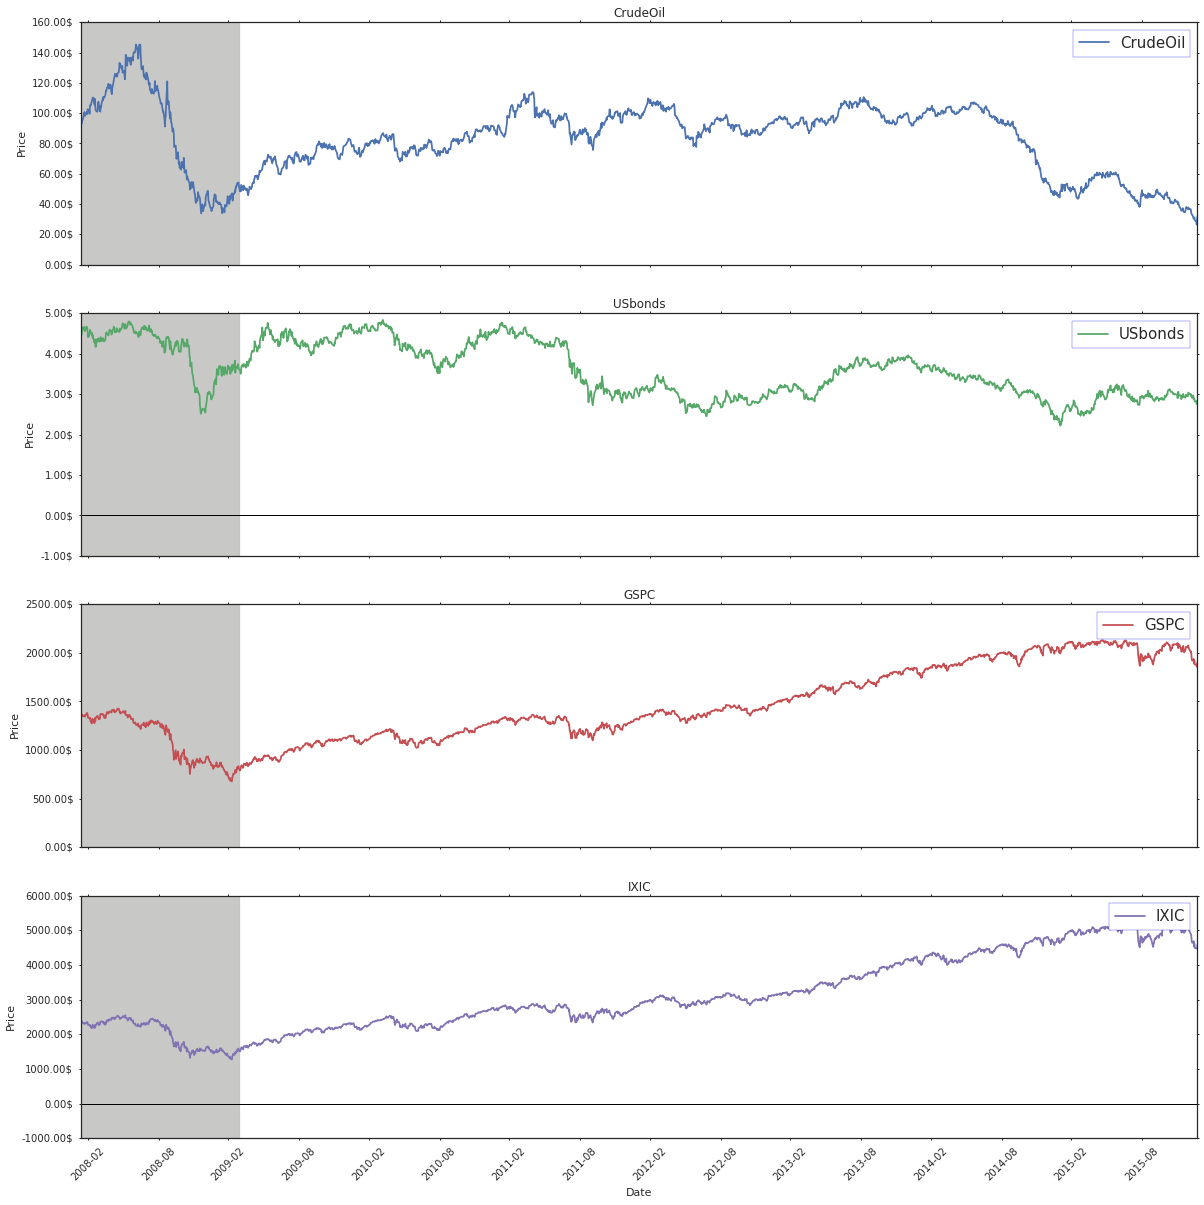

In [28]:
sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))
sns.set_palette(sns.color_palette("deep", 10))

plot_cols = ['CrudeOil', 'USbonds', 'GSPC', 'IXIC']

fig, axes = plt.subplots(4,1, figsize=(20,20), sharex=True)
df[plot_cols].plot(subplots=True, ax=axes)

for ax, col in zip(axes, plot_cols):
    ax.axvspan(*mdates.datestr2num(['09/01/2007', '31/3/2009']),\
               color=sns.xkcd_rgb['grey'], alpha=0.5)
    ax.axhline(0, color='k', linestyle='-', linewidth=1)
    
    ax.set_title(col)
    
    ax.set_ylabel('Price')
    ax.set_xlabel('Date')
    
    ax.legend(fontsize=15, frameon=True).get_frame().set_edgecolor('blue')  
        
    yticks = ax.get_yticks()
    ax.set_yticklabels(['{:3.2f}$'.format(x) for x in yticks]);

    dates_rng = pd.date_range(df.index[0], df.index[-1], freq='6M')

    plt.xticks(dates_rng, [dtz.strftime('%Y-%m') for dtz in dates_rng], rotation=45)

<div class="alert alert-success">
We highlighted the initial section of the graphs to emphasize the trends of the factors during the 2008 financial crisis.
<br>
<h3>Crude Oil Analysis</h3>
<br>
The oil price almost tripled from \$50 to \$147 from early 2007 to July 3, 2008, before plunging as the financial crisis took hold in late 2008. 
<br>
On October 19, 2007, U.S. light crude rose to \$90.02 per barrel due to a combination of ongoing tensions in eastern Turkey and the reducing strength of the U.S. dollar.
<br>
On January 2, 2008, U.S. light crude surpassed \$100 per barrel before falling to \$99.69 due to tensions on New Years Day in Nigeria.
<br>
On March 5, 2008, OPEC accused the United States of economic "mismanagement" that was pushing oil prices to record highs, rebuffing calls to boost output and laying blame at the George W. Bush administration. Oil prices surged above \$110
<br>
On June 6, prices rose \$11 in 24 hours, the largest gain in history due to the possibility of an Israeli attack on Iran.
<br>
On July 15, 2008, a bubble-bursting sell-off began after remarks by President Bush the previous day that the ban on oil drilling would be lifted. This precipitated an \$8 drop, the biggest since the first US-Iraq war. By the end of the week, crude oil fell 11 % to \$128, also affected by easing of tensions between the US and Iran. By August 13, prices had fallen to \$113 a barrel. By the middle of September, oil price fell below \$100 for the first time in over six months, falling below \$92 in the aftermath of the Lehman Brothers bankruptcy.

<br>
<h3>US Bonds Analysis</h3>
<br>
On September the 15th, with the collapse of the investment bank Lehman Brothers, we find the drastic fall of US treasury bonds. We need to note that it is the yield, not the price, of 30-year Treasury bonds. The decrease in the bond yield means the increase in the bond price. The chart shows, therefore, that the Treasury bonds surged. 
<br><br>
Then, what boosted the bond prices? Fundamentally, there are three factors that drive bond prices: 
<ul>
<li> Expected inflation rate
<li> Expected real economic growth
<li> Risk premium
</ul>
<br>
First, buying bonds is to lend money to somebody. So if you lend \$1,000 and receive the same amount of money after some time under inflation of 10%, you are effectively losing the 10% that you'd have earned buying some goods. 
<br>
If the inflation rate is too high, you would prefer buying things instead of lending money, so this is how inflation affects interest rates.
<br>
Second, companies would choose to borrow money as long as the interest rate is lower than the expected gain from the business they could do with borrowing. So real interest rates should be, in a long term, the same as the real economic growth.
<br>
Lastly, interest rates are affected by credibility of a borrower; if you lend money to almost-bankrupt companies, you would require high yields. The increase in the rate due to borrower’s credibility is called risk premium.
As the risk premium for advanced economy’s government bonds, such as the US, is normally considered to be near zero, the calculation of long-term interest rates is theoretically the following:
<br>
<br>
<center>
Long-term <b>interest rate</b> = Expected <b>inflation rate</b> + Expected <b>economic growth</b>
</center>
<br>
Now, by looking at this formula and knowing that the inflation rate fell accompanied by a non-positive value of expected economic growth due to the crisis, we understand what drove the interest rates of US treasury bonds. The gold price fell due to the same cause. 

<br>
<h3>GSPC Analysis</h3> 
<br>
On November 20, 2008, the index closed at 752.44, its lowest since early 1997. A modest recovery the following day still left the index down 45.5% for the year. This year-to-date loss was the greatest since 1931, when the broad market declined more than 50%. The index closed the year at 903.25, for a loss of 38.5%. The market continued to decline in early 2009, surrounding the financial crisis of 2008. The index reached a nearly 13-year low, closing at 676.53, on March 9, 2009.

<br>
<h3>IXIC Analysis</h3> 
<br>
The failure of Lehman Brothers in September 2008 brought world financial markets into turmoil and the NASDAQ composite was no exception, experiencing record levels of market volatility. On September 29, the NASDAQ dropped nearly 200 points, the most since the tech bubble burst, losing 9.14% (third largest in history) to fall beneath the 2,000 level. Conversely, on October 13, 2008, the NASDAQ recorded a gain of nearly 200 points (more than 11%). On March 9, 2009, the composite hit a six-year intra-day low of 1,265.52 before recovering under the influence of Federal Reserve quantitative easing (QE).

</div>



In [2]:
df = web.DataReader("aapl", 'yahoo', datetime(2007, 10, 1), datetime(2016, 4, 1))

trace = go.Candlestick(x=df.index, open=df.Open, high=df.High, low=df.Low, close=df.Close)
data = [trace]
layout = {
    'title': 'Apple',
    'yaxis': {'title': 'AAPL Stock'},
    'shapes': [{
        'x0': '2007-12-01', 'x1': '2007-12-01',
        'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
        'line': {'color': 'rgb(30,30,30)', 'width': 1}
    }, 
    {
        'x0': '2014-06-09', 'x1': '2014-06-09',
        'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper',
        'line': {'color': 'rgb(30,30,30)', 'width': 1}
    }],
    'annotations': [{
        'x': '2007-12-01', 'y': 1.05, 'xref': 'x', 'yref': 'paper',
        'showarrow': False, 'xanchor': 'left',
        'text': 'Official start of the recession'
    }, 
    {
        'x': '2014-06-09', 'y': 0.07, 'xref': 'x', 'yref': 'paper',
        'showarrow': False, 'xanchor': 'right',
        'text': '1 to 7 share split'
    }]
}
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='aapl-recession-candlestick')

<div class="alert alert-success">
Understanding the dynamics of share markets is a real <b>challenging task</b>. To simplify our task, we put ourselves in the position of basing the market analysis only on 4 simple factors, but indeed the reality is not so simple. 
<br><br>
Take a look, for example, on the chart above (<b>Apple</b> stock value on the market) and in particular on the last <b>share split</b>. This was the AAPL's 4th split that took place on 9 June 2014. This was a 7 for 1 split, meaning for each share of AAPL owned pre-split, the shareholder now owned 7 shares. When a company such as Apple splits its shares, the market capitalization before and after the split takes place remains stable, meaning the shareholder now owns more shares but each are valued at a lower price per share. Often, however, a lower priced stock on a per-share basis can attract a wider range of buyers. If that increased demand causes the share price to appreciate, then the total market capitalization rises post-split.
<br><br>
Share market is an <b>heterogeneous and volatile dynamic system</b> where a simple statement can drastically  change the performance on the market. For instance, look at the AAPL price during 2012. Due to a concern of laking of management vision after Jobs' death (reflected in an expected slowing iPhone sales during that year), on 18th May 2012 AAPL reached a lower value of \$530. Nevertheless, a few months later (precisely on 18th September 2012), after raking a record of 2 million pre-orders in the first 24 hours of the new iPhone 5, Apple's stock reached top high and closed above \$700 for the first time. 
<br><br>
We took Apple just as example to demonstrate the <b>highly unpredictable environment</b> we're working on and to be aware that there are a lot of factors we cannot model or predict (politic stability, <b>speculation</b>, management changes, ...)
</div>

### Stock data pre-processing

Next, we prepare the data for the instruments we consider in this Notebook (i.e., the stocks we want to invest in). 

#### Question 4.3

<div class="alert alert-info">
In this Notebook, we assume that we want to invest on the first 35 stocks out of the total 3000 stocks present in our datasets.

<ul></ul>

Load and prepare all the data for the considered instruments (the first 35 stocks) which have historical information for more than 5 years. This means that all instruments with less than 5 years of history should be removed.

</div>

<div class="label label-success">HINT</div> we suggest to open a terminal window (not on your local machine, but the Notebook terminal that you can find on the Jupyter dashboard) and visually check the contents of the directories holding our dataset, if you didn't do this before! Have a look at how stock data is organized!

In [5]:
def plotDistribution(samples, title=None, xlabel=None, ylabel=None):
    vmin = min(samples)
    vmax = max(samples)
    stddev = np.std(samples)
    
    domain = np.arange(vmin, vmax, (vmax-vmin)/200)
    
    # a simple heuristic to select bandwidth
    bandwidth = 1.06 * stddev * pow(len(samples), -.2)
    
    # estimate density
    kde = KDEUnivariate(samples)

    kde.fit(bw=bandwidth)
    density = kde.evaluate(domain)
    
    # plot
    plt.figure(figsize=(15,5))
    
    if title != None:
        plt.title(title)
    
    if xlabel != None:
        plt.xlabel(xlabel)
        
    if ylabel != None:
        plt.ylabel(ylabel)
    
    plt.plot(domain, density)

    plt.show()

In [6]:
def get_distribution_from_samples(samples):
    vmin = min(samples)
    vmax = max(samples)
    stddev = np.std(samples)
    
    domain = np.arange(vmin, vmax, (vmax-vmin)/250)
    bandwidth = 1.06 * stddev * pow(len(samples), -.2)
    
    kde = KDEUnivariate(samples)
    kde.fit(bw=bandwidth)
    density = kde.evaluate(domain)
    
    return (domain, density)

In [7]:
def process_stock_file(fname):
    try:
        def process_line(line):
            cols = line.split(',')
            date = datetime.strptime(cols[0], "%Y-%m-%d")
            value = float(cols[4])#Close price
            return (date, value)
    
        with open(fname) as f:
            content_w_header = f.readlines()
        # remove the first line 
        # and reverse lines to sort the data by date, in ascending order
            content = content_w_header[1: len(content_w_header)]
            data = list(map(process_line , content))
            data.sort(key=lambda x:x[0])
            return data
        
    except Exception as e:
        return None



# select path of all stock data files in "stock_folder"
files = [join(stock_folder, f) for f in listdir(stock_folder) \
                                     if isfile(join(stock_folder, f))]

# assume that we invest only the first 35 stocks (for faster computation)
files = files[:35]

# read each line in each file, convert it into the format: (date, value)
rawStocks = [process_stock_file(f) for f in files]

# select only instruments which have more than 5 years of history
# Note: the number of business days in a year is 260
number_of_years = 5
rawStocks = list(filter(lambda instrument: instrument is not None, rawStocks))
print('Initial number of stocks: ',len(rawStocks))
rawStocks = list(filter(lambda instrument: len(instrument) >= 5*260, rawStocks))
print('Number of used stocks...: ', len(rawStocks), end='\n\n')
# For testing, print the first 5 entry of the first stock

for i in range(len(rawStocks)):
    print('Stock %d:\tFirst available data: %s' % (i, rawStocks[i][0][0].strftime('%Y-%m-%d')), end='')
    print('\tLast available data: %s' % (rawStocks[i][-1][0].strftime('%Y-%m-%d')))

Initial number of stocks:  35
Number of used stocks...:  29

Stock 0:	First available data: 1997-08-14	Last available data: 2016-01-22
Stock 1:	First available data: 1985-07-01	Last available data: 2016-01-22
Stock 2:	First available data: 2000-01-07	Last available data: 2016-01-22
Stock 3:	First available data: 2007-12-06	Last available data: 2016-01-22
Stock 4:	First available data: 1996-04-30	Last available data: 2016-01-22
Stock 5:	First available data: 2007-09-28	Last available data: 2016-01-22
Stock 6:	First available data: 2003-11-12	Last available data: 2016-01-22
Stock 7:	First available data: 2001-01-03	Last available data: 2016-01-22
Stock 8:	First available data: 2006-11-16	Last available data: 2016-01-22
Stock 9:	First available data: 2006-11-02	Last available data: 2016-01-22
Stock 10:	First available data: 1984-07-19	Last available data: 2016-01-22
Stock 11:	First available data: 1999-05-13	Last available data: 2016-01-22
Stock 12:	First available data: 2005-03-30	Last a

<div class="alert alert-success">
From the first 35 stocks, we filtered out 6 of them. The remaining 29 have data up to 2016, and the one with the shortest history is stock 16, which appears on our dataset with values from 2010.
</div>

<div class="alert alert-success">
During our analysis, we encountered a strange stock behavior. We report it here below. 
</div>

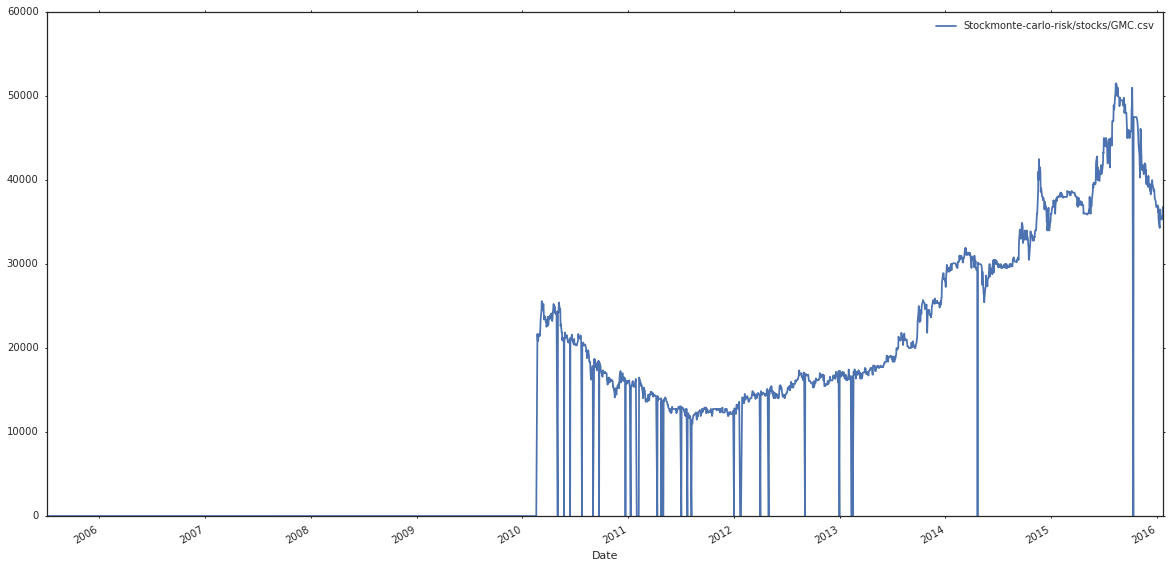

In [68]:
files = [join(stock_folder, f) for f in listdir(stock_folder) \
                                     if isfile(join(stock_folder, f))]
f = files[48]
strange_stock = process_stock_file(f)
df_strange = pd.DataFrame(strange_stock, columns=['Date','Stock'+str(f)])
df_strange = df_strange.set_index('Date')
df_strange.index = df_strange.index.to_datetime()
fig, axes = plt.subplots(1,1, figsize=(20,10), sharex=True)
df_strange.plot(subplots=False, ax=axes)

<div class="alert alert-success">
According to the name of the csv file, we deduce this is the General Motor Company's stock. Two aspects are clearly not correct in this data:
<br>
<ul>
<li> the flat at the beginning corresponds to values in the order of 1e-1, then we have fluctuations in the order of 1e+5 on a 24-hour basis,
<li> stock price is excessively high (it should fluctuate around \$20 and \$40)
</ul>
<br>
According to [4], the most expensive stock is Berkshire Hathaway with US\$209'950 share price, while the second is Seaboard Corporation with around US\$2'752 per share. Since the first stock is not among our files, we think is fair to put a filter on the maximum value of a stock using the second highest (US$2752.56), so as to avoid dealing with corrupted or wrong data.
</div>

In [8]:
start = datetime(year=2009, month=1, day=23)
end = datetime(year=2014, month=1, day=23)

# select path of all stock data files in "stock_folder"
files = [join(stock_folder, f) for f in listdir(stock_folder) \
                                     if isfile(join(stock_folder, f))]

# assume that we invest only the first 35 stocks (for faster computation)
files = files[:35]

# read each line in each file, convert it into the format: (date, value)
rawStocks = [process_stock_file(f) for f in files]

# select only instruments which have more than 5 years of history
# Note: the number of business days in a year is 260
number_of_years = 5
print('Initial number of stocks: ',len(rawStocks))
rawStocks = list(filter(lambda instrument: instrument is not None, rawStocks))
rawStocks = list(filter(lambda instrument: instrument[0][0] <= start, rawStocks))
rawStocks = list(filter(lambda instrument: instrument[-1][0] >= end, rawStocks))
rawStocks = list(filter(lambda instrument: np.max(np.array(instrument)[:,1]) <= 2752.56, rawStocks))
rawStocks = list(filter(lambda instrument: len(instrument) >= 1300, rawStocks))
print('Number of used stocks...: ', len(rawStocks), end='\n\n')
# For testing, print the first 5 entry of the first stock

for i in range(len(rawStocks)):
    print('Stock %d:\tFirst available data: %s' % (i, rawStocks[i][0][0].strftime('%Y-%m-%d')), end='')
    print('\tLast available data: %s' % (rawStocks[i][-1][0].strftime('%Y-%m-%d')))

Initial number of stocks:  35
Number of used stocks...:  28

Stock 0:	First available data: 1997-08-14	Last available data: 2016-01-22
Stock 1:	First available data: 1985-07-01	Last available data: 2016-01-22
Stock 2:	First available data: 2000-01-07	Last available data: 2016-01-22
Stock 3:	First available data: 2007-12-06	Last available data: 2016-01-22
Stock 4:	First available data: 1996-04-30	Last available data: 2016-01-22
Stock 5:	First available data: 2007-09-28	Last available data: 2016-01-22
Stock 6:	First available data: 2003-11-12	Last available data: 2016-01-22
Stock 7:	First available data: 2001-01-03	Last available data: 2016-01-22
Stock 8:	First available data: 2006-11-16	Last available data: 2016-01-22
Stock 9:	First available data: 2006-11-02	Last available data: 2016-01-22
Stock 10:	First available data: 1984-07-19	Last available data: 2016-01-22
Stock 11:	First available data: 1999-05-13	Last available data: 2016-01-22
Stock 12:	First available data: 2005-03-30	Last a

<div class="alert alert-success">
Again, for data cleaning purposes, we removed stocks which do not have data at least from 23/01/2009 an after 23/01/2014, as specified in the next question. This filtered out stock 16 which started in 2010, which would have otherwise brought noisy data.
</div>

### Time alignment for our data
Different types of instruments may trade on different days, or the data may have missing values for other reasons, so it is important to make sure that our different histories align. First, we need to trim all of our time series to the same region in time. Then, we need to fill in missing values. To deal with time series that have missing values at the start and end dates in the time region, we simply fill in those dates with nearby values in the time region.

#### Question 4.4
<div class="alert alert-info">
Assume that we only focus on the data from 23/01/2009 to 23/01/2014. Write a function named `trimToRegion` to select only the records in that time interval. 

<ul></ul>

**Requirements**: after processing, each instrument $i$ has a list of records: $[r_0, r_2,...,r_{m_i}]$ such that $r_0$ and $r_{m_i}$ are assigned, respectively, the first and the last values corresponding to the extremes of the given time interval. For example: $r_0$ should contain the value at date 23/01/2009.
</div>

In [9]:
def trimToRegion(history, start, end):
    def isInTimeRegion(entry):
        (date, value) = entry
        return date >= start and date <= end

    # only select entries which are in the time region
    trimmed = list(filter(lambda x : isInTimeRegion(x), history))
    
    # if the data has incorrect time boundaries, add time boundaries
    if trimmed[0][0] != start:
        trimmed.insert(0, (start, trimmed[0][1]))
    if trimmed[-1][0] != end:
        trimmed.append((end, trimmed[-1][1]))
    return trimmed
    
# test our function
trimmedStock0 = trimToRegion(rawStocks[0], start, end)
# the first 5 records of stock 0
pprint(trimmedStock0[:5])
# the last 5 records of stock 0
pprint(trimmedStock0[-5:])

assert(trimmedStock0[0][0] == start), \
        "the first record must contain the price in the first day of time interval"
assert(trimmedStock0[-1][0] == end), \
        "the last record must contain the price in the last day of time interval"


[(datetime.datetime(2009, 1, 23, 0, 0), 19.549999),
 (datetime.datetime(2009, 1, 26, 0, 0), 19.809999),
 (datetime.datetime(2009, 1, 27, 0, 0), 20.09),
 (datetime.datetime(2009, 1, 28, 0, 0), 21.620001),
 (datetime.datetime(2009, 1, 29, 0, 0), 19.82)]
[(datetime.datetime(2014, 1, 16, 0, 0), 37.400002),
 (datetime.datetime(2014, 1, 17, 0, 0), 37.380001),
 (datetime.datetime(2014, 1, 21, 0, 0), 37.82),
 (datetime.datetime(2014, 1, 22, 0, 0), 37.68),
 (datetime.datetime(2014, 1, 23, 0, 0), 36.77)]


### Dealing with missing values
We expect that we have the price of instruments and factors **in each business day**. Unfortunately, there are many missing values in our data: this means that we miss data for some days, e.g. we have data for the Monday of a certain week, but not for the subsequent Tuesday. So, we need a function that helps filling these missing values.

Next, we provide to you the function to fill missing value: read it carefully!

In [10]:
def fillInHistory(history, start, end):
    curr = history
    filled = []
    idx = 0
    curDate = start
    numEntries = len(history)
    while curDate < end:
        
        # if the next entry is in the same day
        # or the next entry is at the weekend
        # but the curDate has already skipped it and moved to the next monday
        # (only in that case, curr[idx + 1][0] < curDate )
        # then move to the next entry
        while idx + 1 < numEntries and curr[idx + 1][0] <= curDate:
            idx +=1

        # only add the last value of instrument in a single day
        # check curDate is weekday or not
        # 0: Monday -> 5: Saturday, 6: Sunday
        if curDate.weekday() < 5:
            
            filled.append((curDate, curr[idx][1]))
            # move to the next business day
            curDate += timedelta(days=1)
        
        # skip the weekends
        if curDate.weekday() >= 5:
            # if curDate is Sat, skip 2 days, otherwise, skip 1 day
            curDate += timedelta(days=(7-curDate.weekday()))

    return filled

<div class="alert alert-success">
After our data cleaning process, we think we should not have any surprise now, but it's worth performing an additional check on the missing values. 
</div>

In [11]:
def get_missing_statistics(history, start, end):
    curr = list(np.array(history)[:,0])
    filled = []
    idx = 0
    curDate = start
    numEntries = len(history)
    total_days = 0
    missing_days = 0
    #print(curr)
    while curDate < end:
        if curDate.weekday() < 5:
            total_days += 1
            #print((curDate in curr))
            if not (curDate in curr):
                missing_days += 1
        curDate += timedelta(days=1)
        #if curDate.weekday() >= 5:
        #    curDate += timedelta(days=(7-curDate.weekday()))

    return missing_days, total_days, missing_days/total_days

In [12]:
for stock in rawStocks:
    print(get_missing_statistics(stock, start, end))

(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)
(46, 1304, 0.0352760736196319)


<div class="alert alert-success">
We get the same percentage of missing values for every stock, which means we have clean data. It's interesting to notice, though, that all stocks have the same number of missing days and it's reasonable to say that these days may correspond to national holidays.
</div>

#### Question 4.5
<div class="alert alert-info">
Trim data of stocks and factors into the given time interval.
</div>

In [13]:
# trim into a specific time region
# and fill up the missing values
start = datetime(year=2009, month=1, day=23)
end = datetime(year=2014, month=1, day=23)

stocks = list(map(lambda stock: \
            fillInHistory(
                trimToRegion(stock, start, end), 
            start, end), 
        rawStocks))



# merge two factors, trim each factor into a time region
# and fill up the missing values
allfactors = factors1 + factors2
factors = list(map(lambda fact: \
                fillInHistory(
                trimToRegion(fact, start, end), 
                start, end), 
            allfactors))
            
# test our code
print("the first 5 records of stock 0:", stocks[0][:5], "\n")
print("the last 5 records of stock 0:", stocks[0][-5:], "\n")
print("the first 5 records of factor 0:", factors[0][:5], "\n") #
print("the last 5 records of factor 0:", factors[0][-5:], "\n")

the first 5 records of stock 0: [(datetime.datetime(2009, 1, 23, 0, 0), 19.549999), (datetime.datetime(2009, 1, 26, 0, 0), 19.809999), (datetime.datetime(2009, 1, 27, 0, 0), 20.09), (datetime.datetime(2009, 1, 28, 0, 0), 21.620001), (datetime.datetime(2009, 1, 29, 0, 0), 19.82)] 

the last 5 records of stock 0: [(datetime.datetime(2014, 1, 16, 0, 0), 37.400002), (datetime.datetime(2014, 1, 17, 0, 0), 37.380001), (datetime.datetime(2014, 1, 20, 0, 0), 37.380001), (datetime.datetime(2014, 1, 21, 0, 0), 37.82), (datetime.datetime(2014, 1, 22, 0, 0), 37.68)] 

the first 5 records of factor 0: [(datetime.datetime(2009, 1, 23, 0, 0), 46.47), (datetime.datetime(2009, 1, 26, 0, 0), 45.73), (datetime.datetime(2009, 1, 27, 0, 0), 41.58), (datetime.datetime(2009, 1, 28, 0, 0), 42.16), (datetime.datetime(2009, 1, 29, 0, 0), 41.44)] 

the last 5 records of factor 0: [(datetime.datetime(2014, 1, 16, 0, 0), 93.96), (datetime.datetime(2014, 1, 17, 0, 0), 94.37), (datetime.datetime(2014, 1, 20, 0, 0), 

<div class="alert alert-success">
<h1>Visualization of our stocks in the region of interest</h1>
<br>
Since by chance we have spotted some strange behaviors in some stock files, to be sure that all the available data is not corrupted, we printed the share value of all the available stocks.
</div>

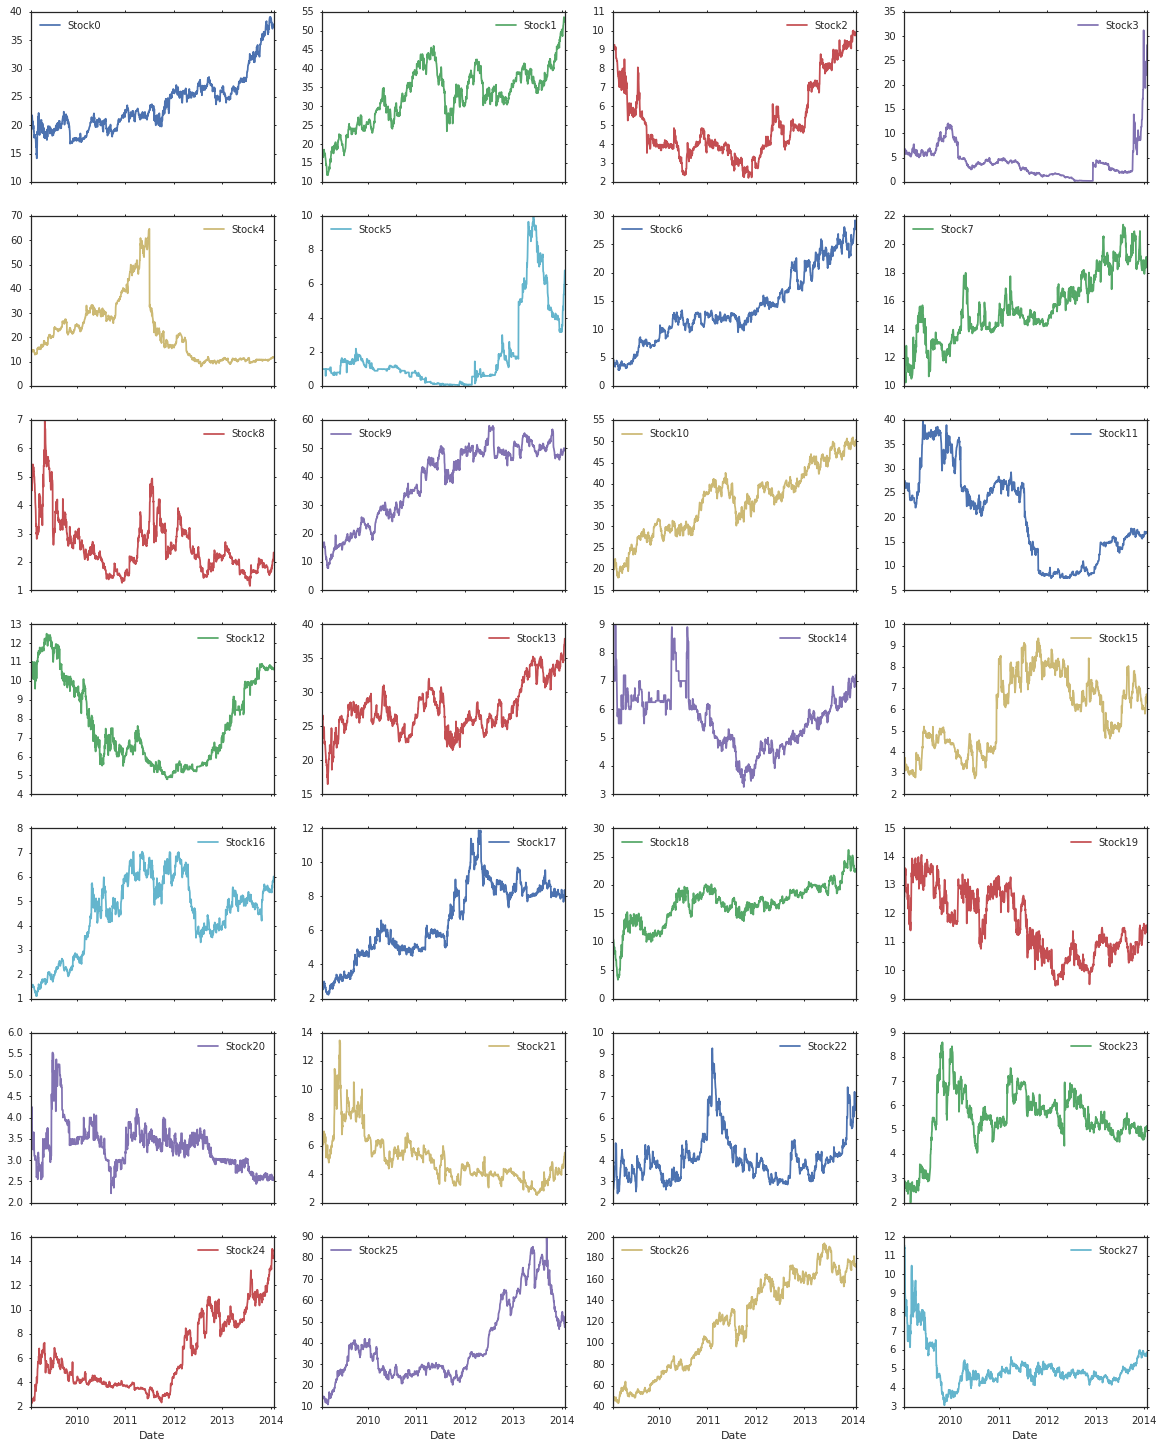

In [84]:
df = [None for i in range(len(stocks))]

for i in range(len(stocks)):
    df[i] = pd.DataFrame(stocks[i], columns=['Date','Stock'+str(i)])
tmp = df[0]
for i in range(len(df)-1):
    tmp = tmp.merge(df[i+1], on=['Date'], how='inner')
df = tmp
df = df.set_index('Date')
df.index = df.index.to_datetime()

sns.set_palette(sns.color_palette("deep", 11))
fig, axes = plt.subplots(7,4, figsize=(20,25), sharex=True)
df.plot(subplots=True, ax=axes)

plt.show()

<div class="alert alert-success">
Everything seems to be correct and, therefore, we can proceed.
</div>

Recall that Value at Risk (VaR) deals with **losses over a particular time horizon**. We are not concerned with the absolute prices of instruments, but how those prices **change over** a given period of time. In our project, we will set that length to two weeks: we use the sliding window method to transform time series of prices into an overlapping sequence of price change over two-week intervals.

The figure below illustrates this process. The returns of market factors after each two-week interval is calculated in the very same way.

![](https://dl.dropboxusercontent.com/s/r9ucsicichb6gjh/two-week-time-interval.svg)

In [14]:
def buildWindow(seq, k=2):
    "Returns a sliding window (of width k) over data from iterable data structures"
    "   s -> (s0,s1,...s[k-1]), (s1,s2,...,sk), ...                   "
    it = iter(seq)
    result = tuple(islice(it, k))
    if len(result) == k:
        yield result  
    for elem in it:
        result = result[1:] + (elem,)
        yield result

#### Question 4.6
<div class="alert alert-info">
Compute the returns of the stocks after each two-week time window.
</div>

In [15]:
def calculateReturn(window):
    # return the change of value after two weeks
    return window[-1][1] - window[0][1]

def twoWeekReturns(history, days=10):
    # we use 10 instead of 14 to define the window
    # because financial data does not include weekends
    return [calculateReturn(entry) for entry in buildWindow(history, days)]

stocksReturns = list(map(twoWeekReturns, stocks))
factorsReturns = list(map(twoWeekReturns, factors))

# test our functions
print("the first 5 returns of stock 0:", stocksReturns[0][:5])
print("the last 5 returns of stock 0:", stocksReturns[0][-5:])

the first 5 returns of stock 0: [1.0899999999999999, 0.8700009999999985, 0.2999989999999997, -2.3100019999999972, 0.13999899999999954]
the last 5 returns of stock 0: [-1.3099970000000027, -0.6899990000000003, -0.7999989999999997, 0.27999900000000366, -0.11999899999999997]


<div class="alert alert-success">
<h1>Visualization of stocks returns after each two-week time window</h1>
<br>
This is what we would like to predict, thus it's interesting to visualize the problem.
</div>

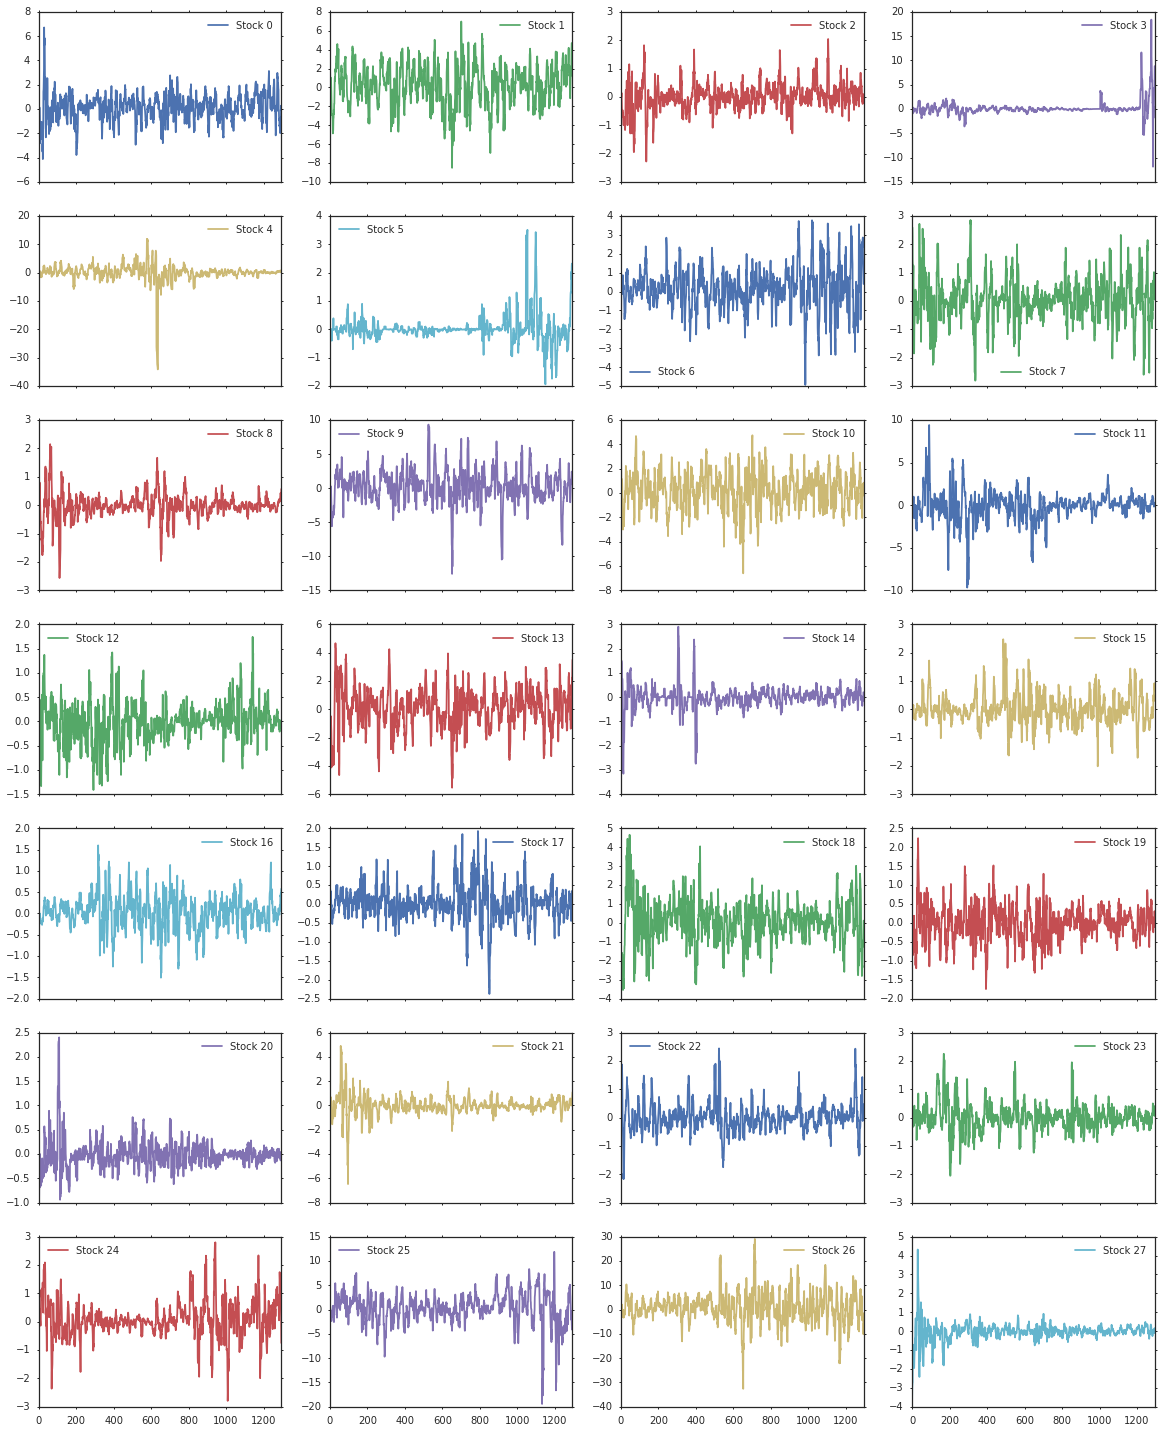

In [91]:
cols_names = ['Stock ' + str(i) for i in range(len(stocksReturns))]
stocks_window_df = pd.DataFrame(np.array(stocksReturns).T, columns=cols_names)

fig, axes = plt.subplots(7,4, figsize=(20,25), sharex=True)
stocks_window_df.plot(subplots=True, ax=axes)
plt.show()

<div class="alert alert-success">
<h1>Visualization of factors returns after each two-week time window</h1>
<br>
Same as before, we plotted the factors returns after each two-week time window. These are the processes that characterize the market condition. The next step is to model the distribution from this random process.
</div>

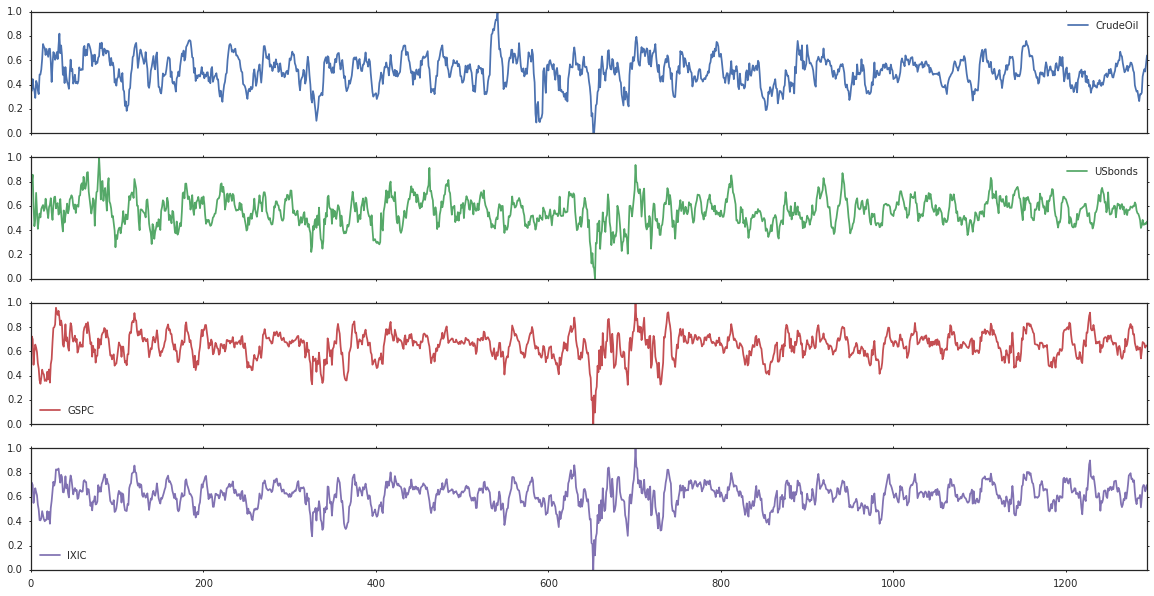

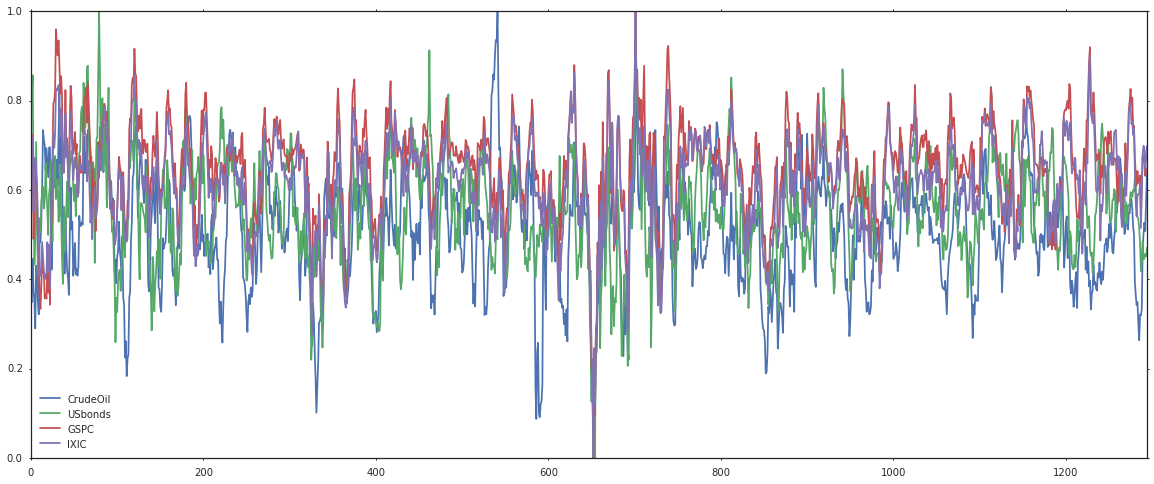

In [164]:
factors_window_df = pd.DataFrame(np.array(factorsReturns).T, \
                                 columns=['CrudeOil','USbonds','GSPC','IXIC'])
factors_window_norm_df = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(np.array(factorsReturns).T), \
                                 columns=['CrudeOil','USbonds','GSPC','IXIC'])

plot_cols = ['CrudeOil', 'USbonds', 'GSPC', 'IXIC']

fig, axes = plt.subplots(4,1, figsize=(20,10), sharex=True)
factors_window_norm_df[plot_cols].plot(subplots=True, ax=axes)
plt.show()

fig, axes = plt.subplots(1,1, figsize=(20,8), sharex=True)
factors_window_norm_df[plot_cols].plot(subplots=False, ax=axes)
plt.show()

<div class="alert alert-success">
It's interesting to note that these factors have some common windows in which the return is lower, but not many windows in which all of the factors have are high returns. This could mean that a bad two-week market trading affects all the factors, while a good one affects only one or two of them. 
</div>

<div class="alert alert-danger">
We spotted an error in fillInHistory function.
<br><br>
Using it as it was provided to us yielded the following bug: for USbonds it was replacing useful data as if it was not present in the file. 
<br><br>
We report here this wrong behavior: at a certain point somehow we had 0 return for each window.
</div>

In [99]:
print(factors_window_df['USbonds'][1115:1125], end='\n\n')
print(factors_window_df['USbonds'][1284:1295])

1115    0.141
1116    0.116
1117    0.099
1118    0.109
1119    0.101
1120    0.000
1121    0.000
1122    0.000
1123    0.000
1124    0.000
Name: USbonds, dtype: float64

1284    0
1285    0
1286    0
1287    0
1288    0
1289    0
1290    0
1291    0
1292    0
1293    0
1294    0
Name: USbonds, dtype: float64


<div class="alert alert-danger">
This is the file as it has been read.
</div>

In [100]:
allfactors[1][-632:-622]

[(datetime.datetime(2014, 1, 9, 0, 0), 3.88),
 (datetime.datetime(2014, 1, 10, 0, 0), 3.802),
 (datetime.datetime(2014, 1, 12, 0, 0), 3.801),
 (datetime.datetime(2014, 1, 13, 0, 0), 3.775),
 (datetime.datetime(2014, 1, 14, 0, 0), 3.804),
 (datetime.datetime(2014, 1, 15, 0, 0), 3.824),
 (datetime.datetime(2014, 1, 16, 0, 0), 3.773),
 (datetime.datetime(2014, 1, 17, 0, 0), 3.751),
 (datetime.datetime(2014, 1, 20, 0, 0), 3.75),
 (datetime.datetime(2014, 1, 21, 0, 0), 3.75)]

<div class="alert alert-danger">
This is the factor after the original fillInHistory.
</div>

In [101]:
factors[1][-10:-1]

[(datetime.datetime(2014, 1, 9, 0, 0), 3.096),
 (datetime.datetime(2014, 1, 10, 0, 0), 3.096),
 (datetime.datetime(2014, 1, 13, 0, 0), 3.096),
 (datetime.datetime(2014, 1, 14, 0, 0), 3.096),
 (datetime.datetime(2014, 1, 15, 0, 0), 3.096),
 (datetime.datetime(2014, 1, 16, 0, 0), 3.096),
 (datetime.datetime(2014, 1, 17, 0, 0), 3.096),
 (datetime.datetime(2014, 1, 20, 0, 0), 3.096),
 (datetime.datetime(2014, 1, 21, 0, 0), 3.096)]

<div class="alert alert-danger">
This is the correct version after our modification.
</div>

In [107]:
fillInHistory(trimToRegion(allfactors[1], start, end), start, end)[-10:-1]

[(datetime.datetime(2014, 1, 9, 0, 0), 3.88),
 (datetime.datetime(2014, 1, 10, 0, 0), 3.802),
 (datetime.datetime(2014, 1, 13, 0, 0), 3.775),
 (datetime.datetime(2014, 1, 14, 0, 0), 3.804),
 (datetime.datetime(2014, 1, 15, 0, 0), 3.824),
 (datetime.datetime(2014, 1, 16, 0, 0), 3.773),
 (datetime.datetime(2014, 1, 17, 0, 0), 3.751),
 (datetime.datetime(2014, 1, 20, 0, 0), 3.75),
 (datetime.datetime(2014, 1, 21, 0, 0), 3.75)]

<div class="alert alert-success">
<h1>Visualization of the stocks windows distribution</h1>
</div>

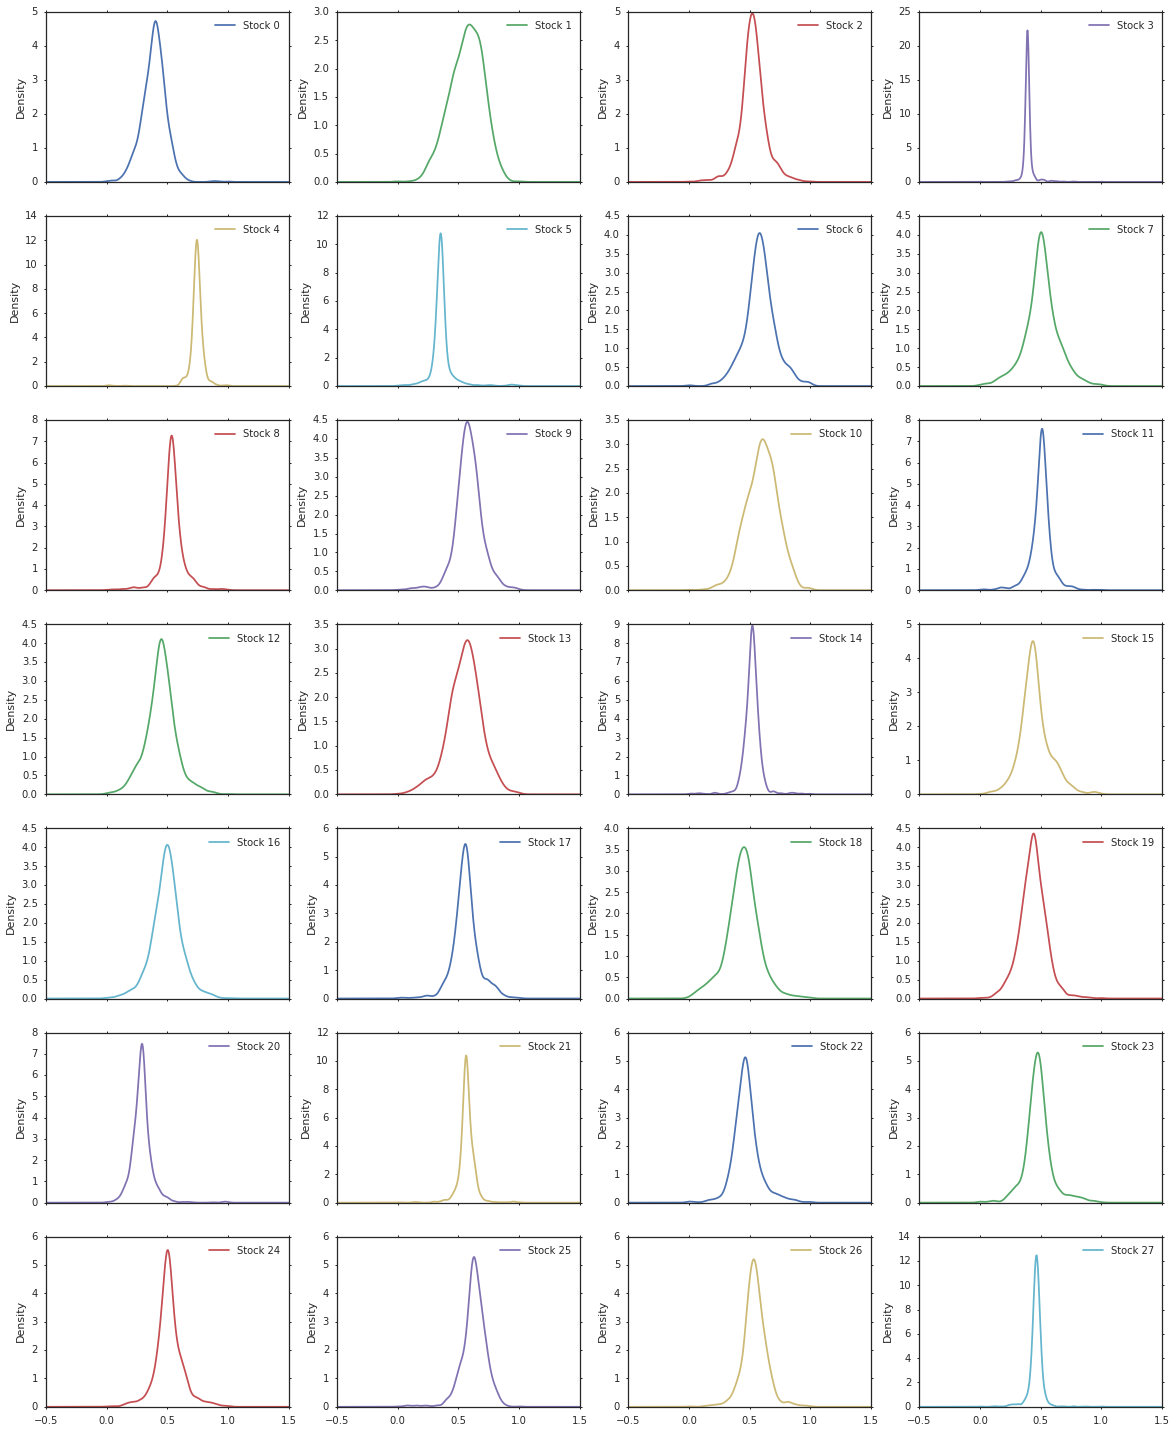

In [97]:
stocks_window_df = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(np.array(stocksReturns).T), columns=cols_names)
fig, axes = plt.subplots(7,4, figsize=(20,25), sharex=True)
stocks_window_df.plot.kde(subplots=True, ax=axes)
plt.show()

<div class="alert alert-success">
These distributions reflect the behavior of the stocks we previously plotted. Wider distributions represents stocks with higher return variance. Look for instance, the distribution for stock3: it has a small variance, justified by the small changes on the return value in 2 weeks (see previous figure).
</div>

Alright! Now we have data that is properly aligned to start the training process: stocks' returns and factors' returns, per time windows of two weeks. Next, we will apply the MCS method.

## 5.5. Summary guidelines to apply the MCS method on the data we prepared
Next, we overview the steps that you have to follow to build a model of your data, and then use Monte Carlo simulations to produce output distributions:

- **Step 1**: Defining the relationship between the market factors and the instrument's returns. This relationship takes the form of a model fitted to historical data.
- **Step 2**: Defining the distributions for the market conditions (particularly, the returns of factors) that are straightforward to sample from. These distributions are fitted to historical data. 
- **Step 3**: Generate the data for each trial of a Monte Carlo run: this amount to generating the random values for market conditions along with these distributions.
- **Step 4**: For each trial, from the above values of market conditions, and using the relationship built in step 1, we calculate the return for each instrument and the total return. We use the returns to define an empirical distribution over losses. This means that, if we run 100 trials and want to estimate the 5% VaR, we would choose it as the loss from the trial with the fifth greatest loss.
- **Step 5**: Evaluating the result

## 5.6. Applying MCS

### Step 1: Defining relationship between market factors and instrument's returns

In our simulation, we will use a simple linear model. By our definition of return, a factor return is a **change** in the value of a market factor **over a particular time period**, e.g. if the value of the S&P 500 moves from 2000 to 2100 over a time interval, its return would be 100.

A vector that contains the return of 4 market factors is called a *market factor vector*. Generally, instead of using this vector as features, we derive a set of features from simple transformation of it. In particular, a vector of 4 values is transformed into a vector of length $m$ by function $F$. In the simplest case $F(v) = v$.

Denote $v_t$ the market factor vector, and $f_t$ the transformed features of $v_t$ at time $t$.

$f_{tj}$ is the value of feature $j$ in $f_t$.

Denote $r_{it}$ the return of instrument $i$ at time $t$ and $c_i$ the [intercept term](http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-to-interpret-the-constant-y-intercept) of instrument $i$.

We will use a simple linear function to calculate $r_{it}$ from $f_t$:

$$
r_{it} = c_i + \sum_{j=1}^{m}{w_{ij}*f_{tj}}
$$

where $w_{ij}$ is the weight of feature $j$ for instrument $i$.

All that above means that given a market factor vector, we have to apply featurization and then use the result as a surrogate for calculating the return of the instruments, using the above linear function.

There are two questions that we should consider: **how we apply featurization to a factor vector?** and **how to pick values for $w_{ij}$?**

**How we apply featurization to a factor vector?**
In fact, the instruments' returns may be non-linear functions of the factor returns. So, we should not use factor returns as features in the above linear function. Instead, we transform them into a set of features with different size. In this Notebook, we can include some additional features in our model that we derive from non-linear transformations of the factor returns. We will try adding two more features for each factor return: its square and its square root values. So, we can still assume that our model is a linear model in the sense that the response variable is a linear function of the new features. *Note that the particular feature transformation described here is meant to be an illustrative example of some of the options that are available: it shouldn't be considered as the state of the art in predictive financial modeling!!*.

**How to pick values for $w_{ij}$?**

For all the market factor vectors in our historical data, we transform them to feature vectors. Now, we have feature vectors in many two-week intervals and the corresponding instrument's returns in these intervals. We can use Ordinary Least Square (OLS) regression model to estimate the weights for each instrument such that our linear function can fit to the data. The parameters for OLS function are:

- `x`: The collection of columns where **each column** is the value of **a feature** in many two-week interval
- `y`: The return of an instrument in the corresponding time interval of x.

The figure below shows the basic idea of the process to build a statistical model for predicting the returns of stock X.

![](https://dl.dropboxusercontent.com/s/kbjtwmnr4w31uev/process-build-model3.svg)


### Question 5
#### Question 5.1

<div class="alert alert-info">
Currently, our data is in form of:  

$$
factorsReturns=
\begin{bmatrix}
 r_{00} & r_{01} & r_{02} & ... & r_{0k} \\
 r_{10} & r_{11} & r_{12} & ... & r_{1k} \\
 ... & ... & ... & ... & ... \\
 r_{n0} & r_{n1} & r_{n2} & ... & r_{nk}\\
\end{bmatrix}
$$

<ul></ul>

$$
stocksReturns=
\begin{bmatrix}
 s_{00} & s_{01} & s_{02} & ... & s_{0k} \\
 s_{10} & s_{11} & s_{12} & ... & s_{1k} \\
 ... & ... & ... & ... & ... \\
 s_{n0} & s_{n1} & s_{n2} & ... & s_{nk}\\
\end{bmatrix}
$$

<ul></ul>

Where, $r_{ij}$ is the return of factor $i^{th}$ in time window $j^{th}$, $k$ is the number of time windows, and $n$ is the number of factors. A similar definition goes for $s_{ij}$.

<ul></ul>

In order to use OLS, the parameter must be in form of:

<ul></ul>

$$
x=factorsReturns^T =
\begin{bmatrix}
 r_{00} & r_{10} & ... & r_{n0} \\
 r_{01} & r_{11} & ... & r_{n1} \\
 r_{02} & r_{12} & ... & r_{n2}\\
 ... & ... & ... & ... \\
 r_{0k} & r_{1k} & ... & r_{nk}\\
\end{bmatrix}
$$

<ul></ul>

Whereas, $y$ can be any row in `stocksReturns`.

<ul></ul>

So, we need a function to transpose a matrix. Write a function named `transpose` to do just that.
</div>

In [16]:
def transpose(matrix):
    m = np.asmatrix(matrix)
    return np.array(m.T).tolist()

def transpose2(matrix):
    return [list(i) for i in zip(*matrix)]

def transpose3(matrix):
    return [[matrix[j][i] for j in range(len(matrix))] for i in range(len(matrix[0]))]

# test function
print(transpose([[1,2,3], [4,5,6], [7,8,9]]))
print(transpose2([[1,2,3], [4,5,6], [7,8,9]]))
print(transpose3([[1,2,3], [4,5,6], [7,8,9]]))

assert (transpose([[1,2,3], [4,5,6], [7,8,9]]) == [[1, 4, 7], [2, 5, 8], [3, 6, 9]]),\
        "Function transpose runs incorrectly"
assert (transpose2([[1,2,3], [4,5,6], [7,8,9]]) == [[1, 4, 7], [2, 5, 8], [3, 6, 9]]),\
        "Function transpose runs incorrectly"
assert (transpose3([[1,2,3], [4,5,6], [7,8,9]]) == [[1, 4, 7], [2, 5, 8], [3, 6, 9]]),\
        "Function transpose runs incorrectly"

[[1, 4, 7], [2, 5, 8], [3, 6, 9]]
[[1, 4, 7], [2, 5, 8], [3, 6, 9]]
[[1, 4, 7], [2, 5, 8], [3, 6, 9]]


In [166]:
%timeit transpose(np.random.rand(1000,1000))

10 loops, best of 3: 35.4 ms per loop


In [167]:
%timeit transpose2(np.random.rand(1000,1000))

10 loops, best of 3: 97.7 ms per loop


In [168]:
%timeit transpose3(np.random.rand(1000,1000))

1 loop, best of 3: 302 ms per loop


<div class="alert alert-success">
Since these computations will be done millions of times, it's reasonable to try to optimize as much as possible. Therefore, we explored different solutions to this question and working with numpy proved to be the best choice in terms of time, doing the transpose of a matrix 10 times faster than the pythonic-way to reverse a list.
</div>

#### Question 5.2
<div class="alert alert-info">
Write a function named `featurize` that takes a list factor's returns $[x_1, x_2,...,x_k]$ and transform it into a new list of features $[u_1,u_2,..,u_k, v_1, v_2,..,v_k, x_1,x_2,...,x_k]$.

<ul></ul>

Where,  


$u_i$ = $\left\{
	\begin{array}{ll}
		x_i^2 & \mbox{if } x_i \geq 0 \\
		-x_i^2 & \mbox{if } x_i < 0
	\end{array}
\right.
$

<ul></ul>

and  

$v_i$ = $\left\{
	\begin{array}{ll}
		\sqrt{x_i} & \mbox{if } x_i \geq 0 \\
		-\sqrt{x_i} & \mbox{if } x_i < 0
	\end{array}
\right.
$  

</div>

In [17]:
def featurize(factorReturns):
    squaredReturns = [i**2 if i>=0 else -(i**2) for i in factorReturns]
    squareRootedReturns = [np.sqrt(i) if i>=0 else -np.sqrt(-i) for i in factorReturns]
    # concat new features
    return list(squaredReturns) + list(squareRootedReturns) + list(factorReturns)

print(featurize([4, -9, 25, 2]))
# test our function
assert(featurize([4, -9, 25]) == [16, -81, 625, 2, -3, 5, 4, -9, 25]), \
        "Function runs incorrectly"


[16, -81, 625, 4, 2.0, -3.0, 5.0, 1.4142135623730951, 4, -9, 25, 2]


#### Question 5.3
<div class="alert alert-info">
Using OLS, estimate the weights for each feature on each stock. What is the shape of `weights` (size of each dimension)?  

Explain it.
</div>

In [18]:
def estimateParams(y, x):
    return sm.OLS(y, x).fit().params

# transpose factorsReturns
factorMat = transpose(matrix=factorsReturns)

# featurize each row of factorMat
factorFeatures = list(map(lambda factor:featurize(factor), factorMat))

# OLS require parameter is a numpy array
factor_columns = np.array(factorFeatures)

#add a constant - the intercept term for each instrument i.
factor_columns = sm.add_constant(factor_columns, prepend=True)

# estimate weights
weights = [estimateParams(stockReturns, factor_columns) for stockReturns in stocksReturns]

print("weights:", np.array(weights).shape)

weights: (28, 13)


<div class="alert alert-success">
By looking at the formula to compute the return of instrument i at time t, the weights matrix has shape IxJ, where I is the number of instruments we are considering, and J is the number of features we have. In our case, 28 instruments, since we filtered out some of them from the original 35 when we put the constraint on 5-year history, and 13 features since each factor implies 3 features, plus the constant related to the intercept term.
</div>

### Step 2: Defining the distributions for the market conditions
Since we cannot define the distributions for the market factors directly, we can only approximate their distribution.
The best way to do that, is plotting their value. However, these values may fluctuate quite a lot. 

Next, we show how to use the Kernel density estimation (KDE) technique to approximate such distributions. In brief, kernel density estimation is a way of smoothing out a histogram: this is achieved by assigning (or centering) a probability distribution (usually a normal distribution) to each data point, and then summing. So, a set of two-week-return samples would result in a large number of "super-imposed" normal distributions, each with a different mean. 

To estimate the probability density at a given point, KDE evaluates the PDFs of all the normal distributions at that point and takes their average. The smoothness of a kernel density plot depends on its *bandwidth*, and the standard deviation of each of the normal distributions. For a brief introduction on KDE, please refer to this [link](https://en.wikipedia.org/wiki/Kernel_density_estimation).

In [19]:
def plotDistribution(samples, title=None):
    vmin = min(samples)
    vmax = max(samples)
    stddev = np.std(samples)
    
    domain = np.arange(vmin, vmax, (vmax-vmin)/200)
    
    # a simple heuristic to select bandwidth
    bandwidth = 1.06 * stddev * pow(len(samples), -.2)
    
    # estimate density
    kde = KDEUnivariate(samples)

    kde.fit(bw=bandwidth)
    density = kde.evaluate(domain)
    
    # plot
    plt.figure(figsize=(15,5))
    
    if title != None:
        plt.title(title)
    
    plt.plot(domain, density)

    plt.show()

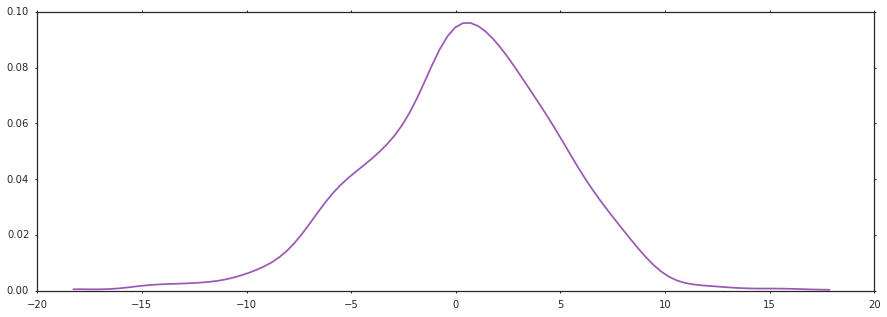

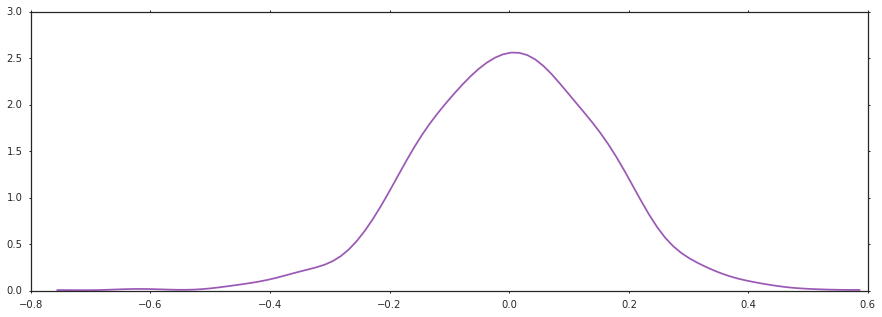

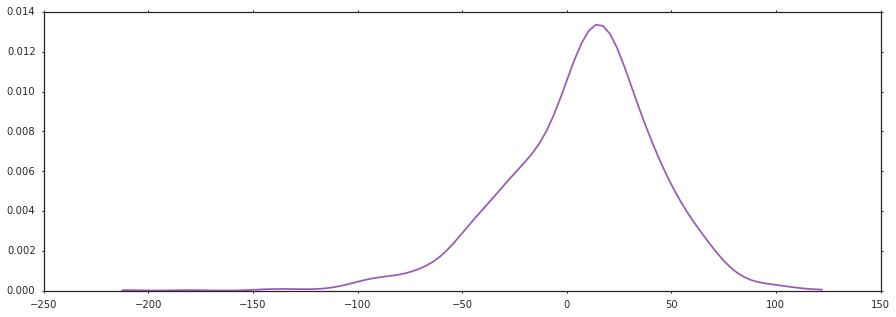

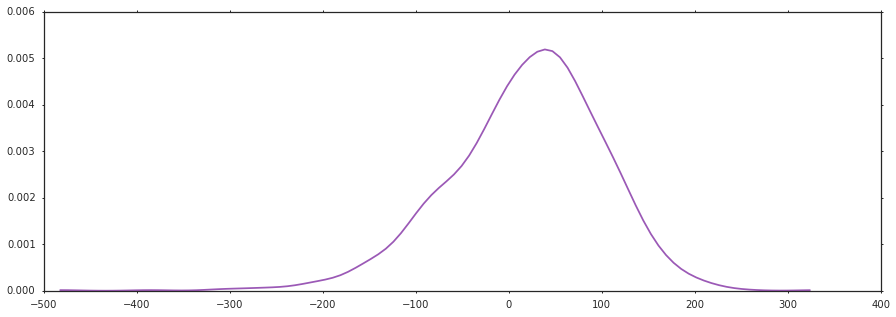

In [17]:
plotDistribution(factorsReturns[0])
plotDistribution(factorsReturns[1])
plotDistribution(factorsReturns[2])
plotDistribution(factorsReturns[3])

For the sake of simplicity, we can say that our smoothed versions of the returns of each factor can be represented quite well by a normal distribution. Of course, more exotic distributions, perhaps with fatter tails, could fit more closely the data, but it is outside the scope of this Notebook to proceed in this way.

Now, the simplest way to sample factors returns is to use a normal distribution for each of the factors, and sample from these distributions independently. However, this approach ignores the fact that market factors are often correlated. For example, when the price of crude oil is down, the price of treasury bonds is down too. We can check our data to verify about the correlation.

### Question 6

#### Question 6.1
<div class="alert alert-info">

Calculate the correlation between market factors and explain the result.

</div>

<div class="label label-success">HINT</div> function `np.corrcoef` might be useful.

In [20]:
correlation = np.corrcoef(factorsReturns)
correlation

array([[ 1.        ,  0.38507954,  0.47411609,  0.45841194],
       [ 0.38507954,  1.        ,  0.55213086,  0.54918324],
       [ 0.47411609,  0.55213086,  1.        ,  0.95227596],
       [ 0.45841194,  0.54918324,  0.95227596,  1.        ]])

<div class="alert alert-success">
The highest correlation value is between GSPC and IXIC factors. This result has already been shown with plots on question 4.2 where we can check they behave similarly on the time period we consider. This is also an expected result due to their nature.
At time of writing, the correlation between Nasdaq and S&P 500 is 0.85, evaluated on a time period of one month [1].
The lowest correlation value is between crude oil and US bonds. This was instead not expected.
<br>
One basic theory in favour of oil and interest rates correlation is that when interest rates rise, consumers and manufacturers cost rise which, in turn, reduces the amount of time and money consumers spend on transportation. The decrease in transportation results in a decrease in consumption which in turn causes oil prices to drop. In this case, interest rates and crude would be inversely correlated. Theoretically then, when interest rates drop, consumers and firms are free to borrow and in turn spend money more freely. Increase consumption drives up demand for oil, and eventually price adjusts to match demand.
<br>
Another theory is that high interest rates strengthen the dollar relatively to other countries' currencies. A strong dollar helps American oil companies buy and import more oil at cheaper prices. Likewise, when the value of the dollar is low, it becomes costlier for American oil companies to import. Thus, a decrease in supply causes oil prices to increase in the U.S. market.
<br>
With that being said, there are factors that affect crude and interest rates independently. Overall economic outlook may give the Federal Reserve the incentive to raise rates or lower rates. For example, when the U.S. faced stagflation (when economic growth is slow and inflation is high) in the 1970s, Volcker raised interest rates to historic highs in order to combat runaway inflation. Factors such as wars, lowered/raised OPEC output, hurricanes, and investor sentiment towards crude are largely uncorrelated to interest rates [2].
</div>

The multivariate normal distribution can help here by taking the correlation information between the factors into account. Each sample from a multivariate normal distribution can be thought of as a vector. Given values for all of the dimensions but one, the distribution of values along that dimension is normal. But, in their joint distribution, the variables are not independent.

For this use case, we can write:

$$
\left(\begin{array}{c}f_{1}\\f_{2}\\f_{3}\\f_{4} \end{array}\right)
\sim N 
\left[
  \left(
    \begin{array}{c}
      \mu_1\\ \mu_2 \\ \mu_3 \\ \mu_4 
    \end{array}
  \right), 
  \left(
    \begin{array}{cccc}
      \sigma^2_1 & \rho_{12} \sigma_1\sigma_2 & \rho_{13} \sigma_1\sigma_3 & \rho_{14} \sigma_1\sigma_4 \\ 
      \rho_{12}\sigma_2\sigma_1 & \sigma^2_2 & \rho_{23} \sigma_2\sigma_3 & \rho_{24} \sigma_2\sigma_4\\
      \rho_{13} \sigma_3\sigma_1 & \rho_{23} \sigma_3\sigma_2 & \sigma^2_3 & \rho_{34} \sigma_3\sigma_4 \\ 
      \rho_{14} \sigma_4\sigma_1 & \rho_{24} \sigma_4\sigma_2 & \rho_{34} \sigma_3\sigma_4 & \sigma_4^2 \\ 
    \end{array}
  \right)
\right]
$$

Or,

$$
f_t \sim N(\mu, \sum)
$$

Where $f_1$, $f_2$, $f_3$ and $f_4$ are the market factors, $\sigma_i$ is the standard deviation of factor $i$, $\mu$ is a vector of the empirical means of the returns of the factors and $\sum$ is the empirical covariance matrix of the returns of the factors.

The multivariate normal is parameterized with a mean along each dimension and a matrix describing the covariance between each pair of dimensions. When the covariance matrix is diagonal, the multivariate normal reduces to sampling along each dimension independently, but placing non-zero values in the off-diagonals helps capture the relationships between variables. Whenever having the mean of this multivariate normal distribution and its covariance matrix, we can generate the sample values for market factors.

Next, we will calculate the mean and the covariance matrix of this multivariate normal distribution from the historical data.


#### Question 6.2
<div class="alert alert-info">

Calculate the covariance matrix $\sum$ and the means $\mu$ of factors' returns then generate a random vector of factors return that follows a multivariate normal distribution $\sim N(\mu, \sum)$

</div>

<div class="label label-success">HINT</div>
Function `np.cov` can help calculating covariance matrix. Function `np.random.multivariate_normal(<mean>, <cov>)` is often used for generating samples.

In [21]:
factorCov = np.cov(factorsReturns)
factorMeans = [sum(factorReturns)/len(factorReturns) for factorReturns in factorsReturns]
sample = np.random.multivariate_normal(factorMeans, factorCov)
print(factorCov)
print(factorMeans)
print(sample)

[[  2.03712313e+01   2.70383097e-01   7.77281497e+01   1.72733934e+02]
 [  2.70383097e-01   2.42014227e-02   3.11994882e+00   7.13264857e+00]
 [  7.77281497e+01   3.11994882e+00   1.31938031e+03   2.88775882e+03]
 [  1.72733934e+02   7.13264857e+00   2.88775882e+03   6.96989443e+03]]
[0.35908880308880364, 0.0019722007722007863, 6.953868592277998, 18.7092272903475]
[   2.21520468   -0.24475258  -50.66716353 -133.63176579]


<div class="alert alert-success">
<h2> Is a simple Gaussian good enough to approximate the real distribution? </h2>
<br>
What we have just done is to approximate the real distribution with a simple multivariate normal distribution. Quantitatively, let's try to visualize the differences between these two density function.
</div>

In [22]:
def plotDistributions(*samples, title=None):
    samples0 = samples[0]
    samples1 = samples[1]

    vmin = min(samples0)
    vmax = max(samples0)
    stddev = np.std(samples0)
    
    domain = np.arange(vmin, vmax, (vmax-vmin)/1000)
    
    # a simple heuristic to select bandwidth
    bandwidth = 1.06 * stddev * pow(len(samples0), -.2)
    
    # estimate density
    kde = KDEUnivariate(samples0)
    kde.fit(bw=bandwidth)
    densityReal = kde.evaluate(domain)
    
    
    kde = KDEUnivariate(samples1)
    kde.fit(bw=bandwidth)
    densityNormal = kde.evaluate(domain)
    
    # plot
    plt.figure(figsize=(15,5))
    plt.plot(domain, densityReal, label='Real distribution')
    plt.plot(domain, densityNormal, label='Proposed distribution')
    plt.legend(loc='upper left')
    if title != None:
        plt.title(title)

    plt.show()
    
    return densityReal, densityNormal

In [21]:
samples = []
total = 100000
for i in range(total):
    if (i+1) % (total/100) == 0:
            if (i+1) % (total/10) == 0:
                print('|', end='')
            else:
                print('.', end='')
    samples.append(np.random.multivariate_normal(factorMeans, factorCov))
samples = np.array(samples)
factorReturnNormalSamples = []
for i in range(4):
    factorReturnNormalSamples.append(samples[:,i])

.........|.........|.........|.........|.........|.........|.........|.........|.........|.........|

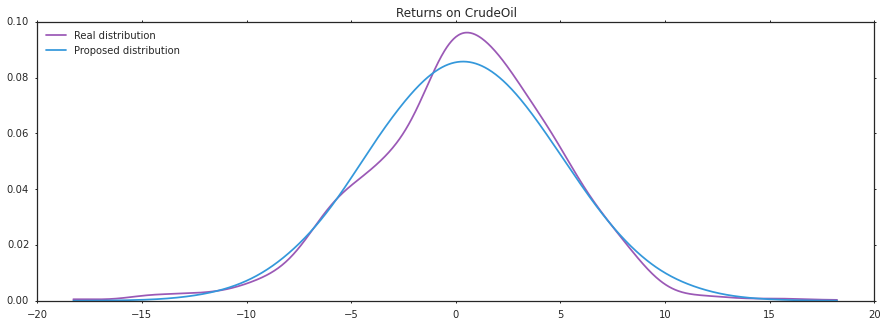

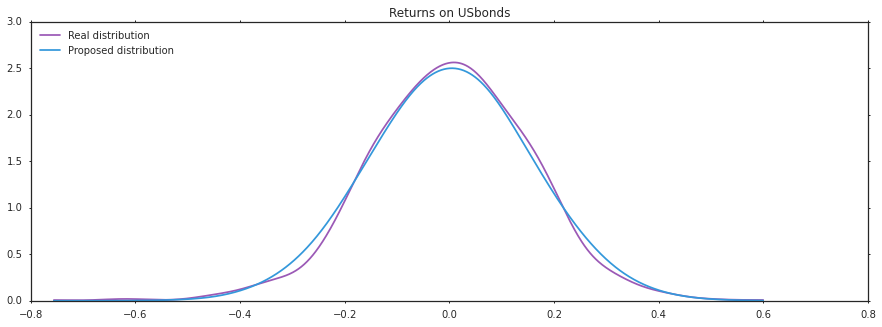

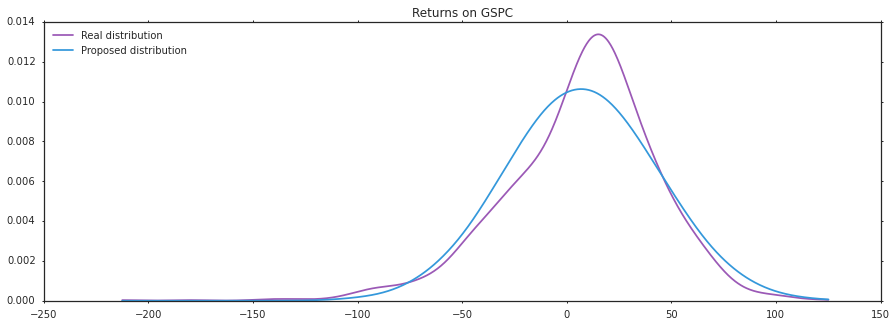

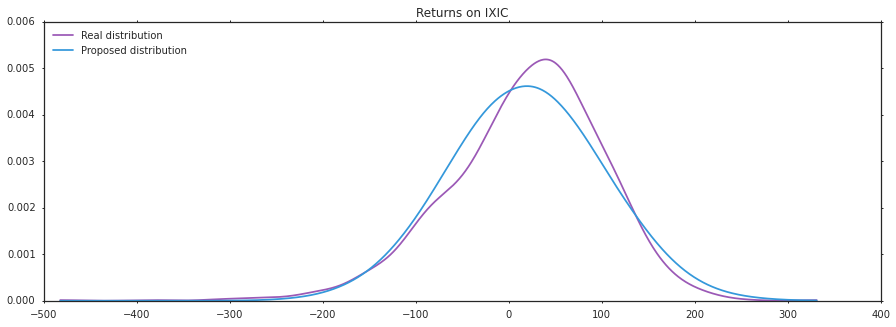

In [22]:
titles = ['CrudeOil', 'USbonds', 'GSPC', 'IXIC']
r0, n0 = plotDistributions(factorsReturns[0], factorReturnNormalSamples[0], title='Returns on ' + titles[0])
r1, n1 = plotDistributions(factorsReturns[1], factorReturnNormalSamples[1], title='Returns on ' + titles[1])
r2, n2 = plotDistributions(factorsReturns[2], factorReturnNormalSamples[2], title='Returns on ' + titles[2])
r3, n3 = plotDistributions(factorsReturns[3], factorReturnNormalSamples[3], title='Returns on ' + titles[3])

<div class="alert alert-success">
Graphically, we can already appreciate some non-negligible differences between the two distributions and the non-symmetry of some of them (in particular on GSPC and IXIC).
<br><br>
To better quantify the differences between distributions, we introduce a commonly used measure: the <b>Kullback–Leibler divergence</b> (or simply <b>KL divergence</b>). Intuitively, given a probability density function $p(x)$ and its approximation $q(x)$, the KL divergence tells the amount of information lost when $q(x)$ is used to approximate $p(x)$ in a certain process. 
<br><br>
Its formulation for continuous functions is the following:
$$
D_{KL}(p(x)||q(x)) = \int_{-\infty}^{+\infty}p(x)\ln\dfrac{p(x)}{q(x)}
$$
Since we're working with discrete distributions, we have to apply its discrete-equivalent:
$$
D_{KL}(p(x)||q(x)) = \sum_{x\in X}p(x)\ln\dfrac{p(x)}{q(x)}
$$
</div>

In [23]:
from scipy.stats import entropy
pdfs = [[r0, n0],[r1, n1],[r2, n2],[r3, n3]]
for i in range(len(pdfs)):
    print(entropy(pk=pdfs[i][0], qk=pdfs[i][1]))

0.0141760494526
0.00892307566858
0.0421649007197
0.0261875626508


<div class="alert alert-success">
As expected, the results are neither 0 nor negligible and worst for the last two factors. Later on we will try with a mixture model to better characterize all aspects of these distributions.
</div>

### Step 3&4: Generating samples, running simulation and calculating the VaR

We define some functions that helps us calculating VaR 5%. You will see that the functions below are pretty complicated! This is why we provide a solution for you: however, study them well!!

The basic idea of calculating VaR 5% is that we need to find a value such that only 5% of the losses are bigger than it. That means the 5th percentile of the losses should be VaR 5%.

VaR can sometimes be problematic though, since it does not give any information on the extent of the losses which can exceed the VaR estimate. CVar is an extension of VaR that is introduced to deal with this problem. Indeed, CVaR measures the expected value of the loss in those cases where VaR estimate has been exceeded.

In [23]:
def fivePercentVaR(trials):
    numTrials = trials.count()
    topLosses = trials.takeOrdered(max(round(numTrials/20.0), 1))
    return topLosses[-1]

# an extension of VaR
def fivePercentCVaR(trials):
    numTrials = trials.count()
    topLosses = trials.takeOrdered(max(round(numTrials/20.0), 1))
    return sum(topLosses)/len(topLosses)

def bootstrappedConfidenceInterval(
      trials, computeStatisticFunction,
      numResamples, pValue):
    stats = []
    for i in range(0, numResamples):
        resample = trials.sample(True, 1.0)
        stats.append(computeStatisticFunction(resample))
    sorted(stats)
    lowerIndex = int(numResamples * pValue / 2 - 1)
    upperIndex = int(np.ceil(numResamples * (1 - pValue / 2)))
    return (stats[lowerIndex], stats[upperIndex])

Next, we will run the Monte Carlo simulation 10,000 times, in parallel using Spark. Since your cluster has 12 cores (two Spark worker nodes, each with 6 cores), we can set `parallelism = 12` to dispatch simulation on these cores, across the two machines (remember, those are not really "physical machines", they are Docker containers running in our infrastructure).

### Question 7
<div class="alert alert-info">
Complete the code below to define the simulation process and calculate VaR 5%.
</div>

In [24]:
def simulateTrialReturns3(numTrials, factorMeans, factorCov, weights):
    trialReturns = []
    for i in range(0, numTrials):
        trialFactorReturns = np.random.multivariate_normal(factorMeans, factorCov)
        trialFeatures = featurize(trialFactorReturns)
        trialFeatures.insert(0,1)
        trialTotalReturn = 0
        tmp = 0
        for i in range(len(weights)):
            tmp += weights[i] * trialFeatures
        trialTotalReturn = sum(tmp)
        trialReturns.append(trialTotalReturn)
    return trialReturns 

def simulateTrialReturns2(numTrials, factorMeans, factorCov, weights):
    trialReturns = []
    weights = np.array(weights)
    for i in range(0, numTrials):
        trialFactorReturns = np.random.multivariate_normal(factorMeans, factorCov)
        trialFeatures = featurize(trialFactorReturns)
        trialFeatures.insert(0,1)
        
        tmp = np.sum(weights.dot(trialFeatures))

        trialReturns.append(tmp)
    return trialReturns 

def simulateTrialReturns(numTrials, factorMeans, factorCov, weights):
    trialReturns = []
    weights=np.array(weights)
    trialFactorReturns = np.random.multivariate_normal(factorMeans, factorCov, size=numTrials)
    trialFeatures = np.apply_along_axis(featurize, axis=1, arr=trialFactorReturns)
    trialFeatures = np.insert(arr=trialFeatures, obj=0, values=1, axis=1)
    tmp = weights.dot(trialFeatures.T).sum(axis=0).tolist()
    return tmp

In [110]:
%timeit -n1000 simulateTrialReturns(10, factorMeans, factorCov, weights)
%timeit -n1000 simulateTrialReturns2(10, factorMeans, factorCov, weights)
%timeit -n1000 simulateTrialReturns3(10, factorMeans, factorCov, weights)

1000 loops, best of 3: 810 µs per loop
1000 loops, best of 3: 2.87 ms per loop
1000 loops, best of 3: 12.6 ms per loop


<div class="alert alert-success">
For the same time-reason as before, we tried to optimize also the <b>sampling&prediction phase</b>. 
<br><br>
The <b>first version</b>, is a straightforward way of implementing a linear regression where all the operations are explicited. The <b>second one</b>, on the other hand, carries out the power of numpy dot product between arrays.
<br><br>
The <b>last version</b>, finally, samples the multivariate normal distribution not only once per trial, but exactly the number of trials needed: it's much faster to call the numpy API only once with thousands of samples. Unfortunately, though, to avoid looping through this matrix and to use numpy matrix operations, we had to change a little bit the way stocks returns are computed. The function has been tested to guarantee proper and true results.
<br><br>
The final one has been proved to be the fastest with up to <b>15X improvement</b> in computational time. 
</div>

In [25]:
parallelism = 12
numTrials = 250000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)

trials = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns(
                    max(int(numTrials/parallelism), 1), 
                    factorMeans, factorCov,
                    weights
                ))
trials.cache()

valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)

print("Value at Risk(VaR) 5%:", valueAtRisk)
print("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk)

Value at Risk(VaR) 5%: -20.035246486166983
Conditional Value at Risk(CVaR) 5%: -25.97474696952884


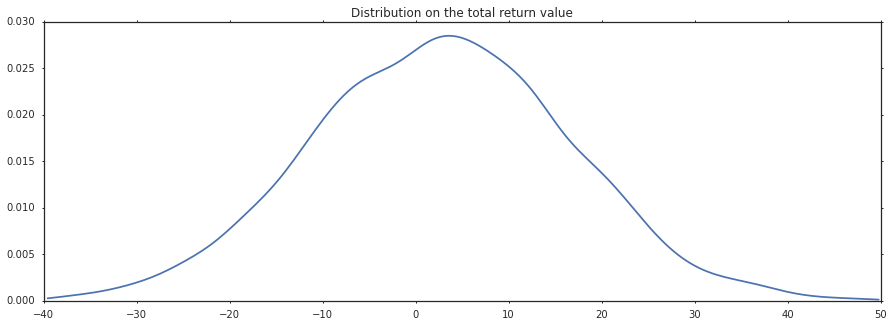

In [29]:
plotDistribution(trials.take(5000), title='Distribution on the total return value')

<div class="alert alert-success">
Here the representation of <b>VaR</b>. According to the model, there is 5% of probability to lose more than \$20 on two weeks of investment.
</div>

The value of VaR depends on how many invested stocks and the chosen distribution of random variables. Assume that we get VaR 5% = -2.66,  that means that there is a 0.05 probability that the portfolio will fall in value by more than \$2.66 over a two weeks' period if there is no trading. In other words, the loses are less than \$2.66 over two weeks' period with 95% confidence level. When a loss over two weeks is more than \$2.66, we call it **failure** (or **exception**). Informally, because of 5% probability, we expect that there are only $0.05*W$ failures out of total $W$ windows.

### Step 5: Evaluating the results using backtesting method
In general, the error in a Monte Carlo simulation should be proportional to 1/sqrt(n), where n is the number of trials. This means, for example, that quadrupling the number of trials should approximately cut the error in half. A good way to check the quality of a result is backtesting on historical data. Backtesting is a statistical procedure where actual losses are compared to the estimated VaR. For instance, if the confidence level used to calculate VaR is 95% (or VaR 5%), we expect only 5 failures over 100 two-week time windows.

The most common test of a VaR model is counting the number of VaR failures, i.e., in how many windows, the losses exceed VaR estimate. If the number of exceptions is less than selected confidence level would indicate, the VaR model overestimates the risk. On the contrary, if there are too many exceptions, the risk is underestimated. However, it's very hard to observe the amount of failures suggested by the confidence level exactly. Therefore, people try to study whether the number of failures is reasonable or not, or will the model be accepted or rejected.

One common test is Kupiec's proportion-of-failures (POF) test. This test considers how the portfolio performed at many historical time intervals and counts the number of times that the losses exceeded the VaR. The null hypothesis is that the VaR is reasonable, and a sufficiently extreme test statistic means that the VaR estimate does not accurately describe the data. The test statistic is computed as:

$$
-2ln\Bigg(\frac{(1-p)^{T-x}p^x}{(1-\frac{x}{T})^{T-x}(\frac{x}{T})^x}\Bigg)
$$

where:

$p$ is the quantile-of-loss of the VaR calculation (e.g., in VaR 5%, p=0.05),

$x$ (the number of failures) is the number of historical intervals over which the losses exceeded the VaR 

$T$ is  the total number of historical intervals considered

Or we can expand out the log for better numerical stability:

$$
\begin{equation}
-2\Big((T-x)ln(1-p)+x*ln(p)-(T-x)ln(1-\frac{x}{T})-x*ln(\frac{x}{T})\Big)
\end{equation}
$$

If we assume the null hypothesis that the VaR is reasonable, then this test statistic is drawn from a chi-squared distribution with a single degree of freedom. By using Chi-squared distribution, we can find the `p-value` accompanying our test statistic value.  If `p-value` exceeds the critical value of the Chi-squared distribution, we do have sufficient evidence to reject the null hypothesis that the model is reasonable. Or we can say, in that case, the model is considered as inaccurate.

For example, assume that we calculate VaR 5% (the confidence level of the VaR model is 95%) and get value VaR = 2.26. We also observed 50 exceptions over 500 time windows. Using the formula above, the test statistic `p-value` is calculated and equal to `8.08`. Compared to `3.84`, the critical value of Chi-squared distribution with one degree of freedom at probability 5%, the test statistic is larger. So, the model is rejected. The critical values of Chi-squared can be found by following [this link](https://people.richland.edu/james/lecture/m170/tbl-chi.html).
However, in this Notebook, it's not a good idea to find the corresponding critical value by looking in a "messy" table, especially when we need to change the confidence level. Instead, from `p-value`, we will calculate the probability of the test statistic in Chi-square thanks to some functions in package `scipy`. If the calculated probability is smaller than the quantile of loss (e.g, 0.05), the model is rejected and vice versa.


### Question 8

#### Question 8.1
<div class="alert alert-info">

Write a function to calculate the number of failures, that is when the losses (in the original data) exceed the VaR.

</div>

<div class="label label-success">HINT</div>
<ul>
  <li>First, we need to calculate the total loss in each 2-week time interval</li>
  <li>If the total loss of a time interval exceeds VaR, then we say that our VaR fails to estimate the risk in that time interval</li>
  <li>Return the number of failures</li>
</ul>  

<div class="label label-danger">NOTE</div> The loss is often having negative value, so, be careful when compare it to VaR.

In [30]:
def countFailures(stocksReturns, valueAtRisk):
    failures = 0    
    # iterate over time intervals
    for i in range(0, len(stocksReturns[0])):
        # calculate the losses in each time interval
        loss = sum(np.array(stocksReturns)[:,i])
        
        # if the loss exceeds VaR
        if loss < valueAtRisk:        #opposite?! loss > -valueAtRisk:
            failures += 1
    return failures

countFailures(stocksReturns, valueAtRisk)

112

<div class="alert alert-success">
Losses already explicit the minus sign as potential negative profit, therefore it's already consistent with the sign of the value at risk.
</div>

#### Question 8.2
<div class="alert alert-info">

Write a function named `kupiecTestStatistic` to calculate the test statistic which was described in the above equation.

</div>

In [31]:
def kupiecTestStatistic(total, failures, confidenceLevel):
    failureRatio = failures/total
    logNumer = (total - failures)* np.log(1 - confidenceLevel) + failures * np.log(confidenceLevel)
    logDenom = (total - failures) * np.log(1 - failureRatio) + failures * np.log(failureRatio)
    return -2 * (logNumer - logDenom)
    
# test the function
round(kupiecTestStatistic(250, 36, 0.1), 2)
assert (round(kupiecTestStatistic(250, 36, 0.1), 2) == 4.80), "function kupiecTestStatistic runs incorrectly"

In [79]:
test_stat = kupiecTestStatistic(1295, 139, 0.05)
print(test_stat)

68.4496149014


Now we can find the p-value accompanying our test statistic value.

In [33]:
def kupiecTestPValue(stocksReturns, valueAtRisk, confidenceLevel):
    failures = countFailures(stocksReturns, valueAtRisk)
    print("num failures:", failures)
    if failures == 0:
        # the model is very good
        return 1
    total = len(stocksReturns[0])
    testStatistic = kupiecTestStatistic(total, failures, confidenceLevel)
    return chi2.sf(testStatistic, 1.0)

In [34]:
varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)
print("VaR confidence interval: " , varConfidenceInterval)
print("CVaR confidence interval: " , cvarConfidenceInterval)
print("Kupiec test p-value: " , kupiecTestPValue(stocksReturns, valueAtRisk, 0.05))

VaR confidence interval:  (-19.879541704786632, -19.9743270358284)
CVaR confidence interval:  (-26.0250619977432, -25.98725398759849)
num failures: 112
Kupiec test p-value:  4.14027312859e-08


#### Question 8.3
<div class="alert alert-info">

Discuss the results you have obtained

</div>

<div class="alert alert-success">
Even though the VaR was low (in absolute terms), the number of failure is quite high and this preliminary model did not passed the Kupiec test. This suggests us that the model should be changed or improved. This will be done later on. 
</div>

### Question 9
<div class="alert alert-info">
Assume that we invest in more than 100 stocks. Use the same market factors as for the previous questions to estimate VaR by running MCS, then validate your result.  

What is the main observation you have, once you answer this question? When you plan to invest in more instruments, how is your ability to predict the risk going to be affected?
</div>


<div class="alert alert-success">
Just to simplify things, we re-write all the pipeline here below.
</div>

In [47]:
def read_stocks(num_stocks, stock_folder, \
                start = datetime(year=2009, month=1, day=23),\
                end = datetime(year=2014, month=1, day=23)):

    # select path of all stock data files in "stock_folder"
    files = [join(stock_folder, f) for f in listdir(stock_folder) \
                                         if isfile(join(stock_folder, f))]

    # assume that we invest only the first 35 stocks (for faster computation)
    files = files[:num_stocks]

    # read each line in each file, convert it into the format: (date, value)
    rawStocks = [process_stock_file(f) for f in files]

    # select only instruments which have more than 5 years of history
    # Note: the number of business days in a year is 260
    number_of_years = 5
    print('Initial number of stocks: ',len(rawStocks))
    rawStocks = list(filter(lambda instrument: instrument is not None, rawStocks))
    rawStocks = list(filter(lambda instrument: instrument[0][0] <= start, rawStocks))
    rawStocks = list(filter(lambda instrument: instrument[-1][0] >= end, rawStocks))
    #https://www.msn.com/en-in/money/topstories/10-most-expensive-stocks-in-the-world/ss-BB91I9n#image=10
    rawStocks = list(filter(lambda instrument: np.max(np.array(instrument)[:,1]) <= 2752.56, rawStocks))
    rawStocks = list(filter(lambda instrument: len(instrument) >= 1300, rawStocks))
    print('Number of used stocks...: ', len(rawStocks), end='\n\n')
        
    return rawStocks

def preprocess_stocks(rawStocks,
                      start=datetime(year=2009, month=1, day=23), 
                      end=datetime(year=2014, month=1, day=23)):

    stocks = list(map(lambda stock: \
                        fillInHistory(
                        trimToRegion(stock, start, end), 
                        start, end), rawStocks))
    return stocks

def compute_stocks_returns(stocks):
    return list(map(twoWeekReturns, stocks))
    
def compute_weights(stocksReturns, factorsReturns):
    
    factorMat = transpose(matrix=factorsReturns)
    factorFeatures = list(map(lambda factor:featurize(factor), factorMat))
    factor_columns = np.array(factorFeatures)
    factor_columns = sm.add_constant(factor_columns, prepend=True)
    weights = [estimateParams(stockReturns, factor_columns) for stockReturns in stocksReturns]
    
    return weights

def simulateTrialReturns(numTrials, factorMeans, factorCov, weights):
    trialReturns = []
    weights=np.array(weights)
    trialFactorReturns = np.random.multivariate_normal(factorMeans, factorCov, size=numTrials)
    trialFeatures = np.apply_along_axis(featurize, axis=1, arr=trialFactorReturns)
    trialFeatures = np.insert(arr=trialFeatures, obj=0, values=1, axis=1)
    tmp = weights.dot(trialFeatures.T).sum(axis=0).tolist()
    return tmp

<div class="alert alert-success">
Let's start trying with 100 stocks.
</div>

In [48]:
rawStocks = read_stocks(100, stock_folder)
stocks = preprocess_stocks(rawStocks)
stocksReturns = compute_stocks_returns(stocks)
weights = compute_weights(stocksReturns, factorsReturns)

Initial number of stocks:  100
Number of used stocks...:  69



In [37]:
parallelism = 12
numTrials = 250000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)

trials = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns(
                    max(int(numTrials/parallelism), 1), 
                    factorMeans, factorCov,
                    weights
                ))
trials.cache()

valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)

print("Value at Risk(VaR) 5%:", valueAtRisk)
print("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk)
print("Kupiec test p-value: " , kupiecTestPValue(stocksReturns, valueAtRisk, 0.05))

varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
print("VaR confidence interval: " , varConfidenceInterval)

cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)
print("CVaR confidence interval: " , cvarConfidenceInterval)

Value at Risk(VaR) 5%: -45.619003874633414
Conditional Value at Risk(CVaR) 5%: -58.714169741313206
num failures: 89
Kupiec test p-value:  0.00335526878023
VaR confidence interval:  (-45.47304763719749, -45.63508778156052)
CVaR confidence interval:  (-58.8150907791995, -58.76656455413824)


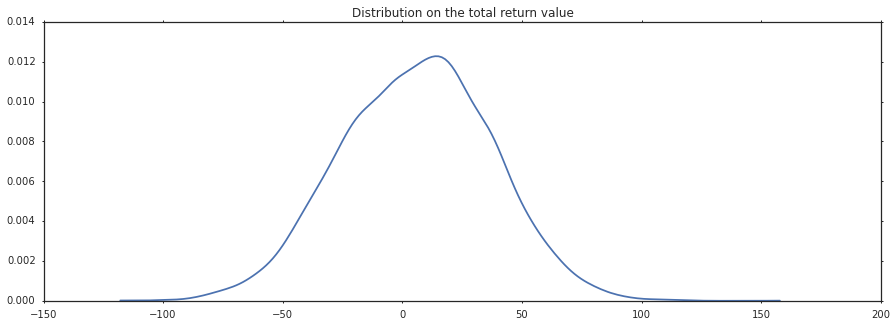

In [38]:
plotDistribution(trials.take(10000), title='Distribution on the total return value')

<div class="alert alert-success">
We spotted some interesting trends here. 
<br><br>
First of all, the <b>VaR</b> has increased: this is due to the fact that more stocks are present in our portfolio, thus the risk associated as expected is higher than before.
On the other hand, the number of failure decreased and this is justified by the <b>diversification of the portfolio</b>. Diversification strives to smooth out unsystematic risk events in a portfolio so the positive performance of some investments neutralizes the negative performance of others. Therefore, the benefits of diversification hold only if the securities in the portfolio are not perfectly correlated.
<br><br>
As a consequence, the model performs a little bit better but it still cannot be accepted as the Kupiec test is lower than 0.05.
</div>

<div class="alert alert-success">
Guided by our curiosity, we tried also with 1000 stocks.
</div>

In [49]:
rawStocks = read_stocks(1000, stock_folder)
stocks = preprocess_stocks(rawStocks)
stocksReturns = compute_stocks_returns(stocks)
weights = compute_weights(stocksReturns, factorsReturns)

Initial number of stocks:  1000
Number of used stocks...:  714



In [40]:
parallelism = 12
numTrials = 250000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)

trials = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns(
                    max(int(numTrials/parallelism), 1), 
                    factorMeans, factorCov,
                    weights
                ))
trials.cache()

valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)

print("Value at Risk(VaR) 5%:", valueAtRisk)
print("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk)
print("Kupiec test p-value: " , kupiecTestPValue(stocksReturns, valueAtRisk, 0.05))

varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
print("VaR confidence interval: " , varConfidenceInterval)

cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)
print("CVaR confidence interval: " , cvarConfidenceInterval)

Value at Risk(VaR) 5%: -531.0469480859258
Conditional Value at Risk(CVaR) 5%: -681.768388129003
num failures: 88
Kupiec test p-value:  0.00483662649563
VaR confidence interval:  (-531.6365896673011, -528.8402407802671)
CVaR confidence interval:  (-684.4119097449102, -679.8453753595046)


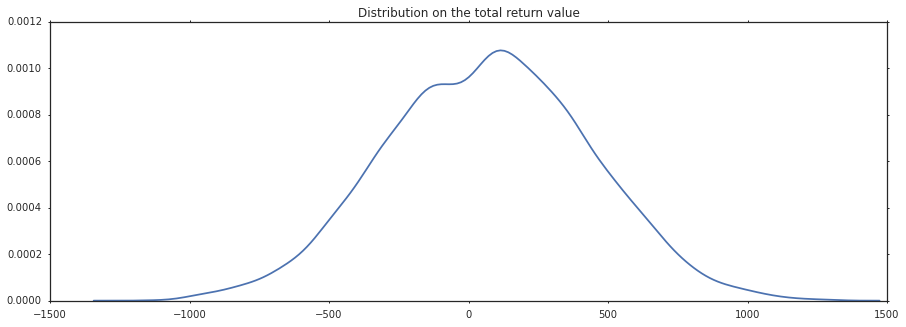

In [41]:
plotDistribution(trials.take(10000), title='Distribution on the total return value')

<div class="alert alert-success">
The trends we highlighted before are confirmed here, even if with less impact: number of failure decreased, VaR increased and the Kupiec test still fails.
</div>

### Question 10
<div class="alert alert-info">

In the previous questions, we used the normal distributions to sample the factors returns.  

Try to study how results vary when selecting other probability distributions: our goal is to improve the result of our MCS.
</div>

<div class="alert alert-success">
Two are the critical factors for a good MCS-based model: <b>distribution on the parameters</b> (i.e. factors returns) and the <b>regression model for the prediction</b> (i.e. stocks returns). Our intent, here, is to better characterize the market condition based on the four factors. 
<br><br>
The natural extension to what we have done before is the use of a mixture model, in particular a <b>Gaussian Mixture Model</b>. A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number ($K$) of Gaussian distributions with unknown parameters:
$$
    {\displaystyle p({\boldsymbol {\theta }})=\sum _{i=1}^{K}\phi _{i}{\mathcal {N}}({\boldsymbol {\mu _{i},\Sigma _{i}}})} 
$$
where the $i$th vector component is characterized by normal distributions with weights $\phi_{i}$, means ${\boldsymbol {\mu _{i}}}$ and covariance matrices ${\boldsymbol {\Sigma _{i}}}$.
<br><br>
The estimation of these parameters is not straighfowrard (one possible method is the <b>EM algorithm</b>) but fortunately this is done directly by the library function.
</div>

In [50]:
def fit_MVGMM(data, components=100):
    '''
        Fit a MultiVariate Gaussian Mixture Model
    '''
    data = np.asarray(data, np.float32)
    GaussianMixture = GMM(n_components=components, covariance_type='full', n_iter=1000, n_init=5, \
                          init_params='kmeans')#, warm_start=True), verbose=2, verbose_interval=10)
    model = GaussianMixture.fit(data)
    return model

def sample_MVGMM(model, num_samples):
    '''
        Sample from a MultiVariate Gaussian Mixture Model
    '''
    return model.sample(num_samples).T

In [51]:
factorsReturns = np.array(factorsReturns)
model = fit_MVGMM(factorsReturns.T)

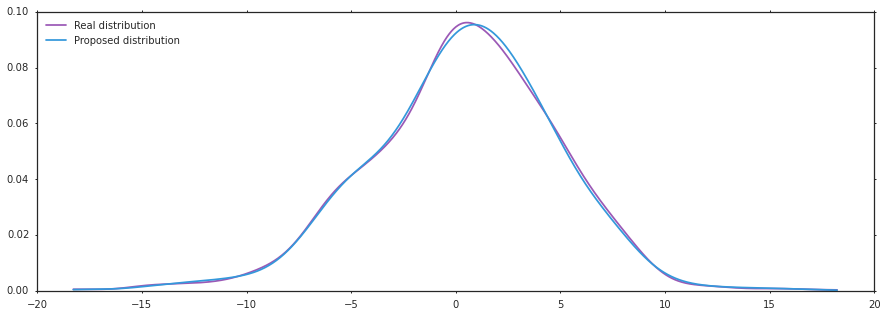

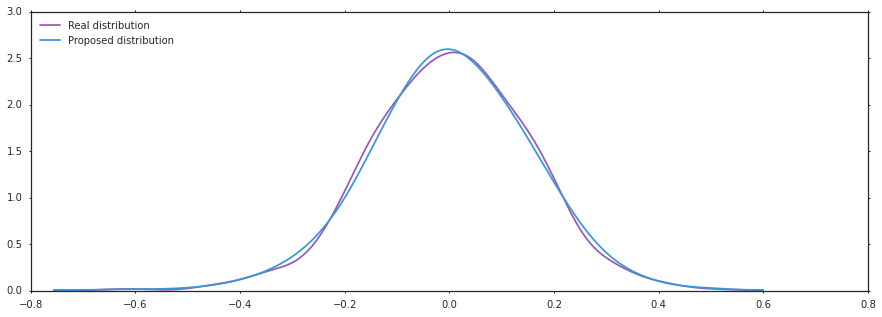

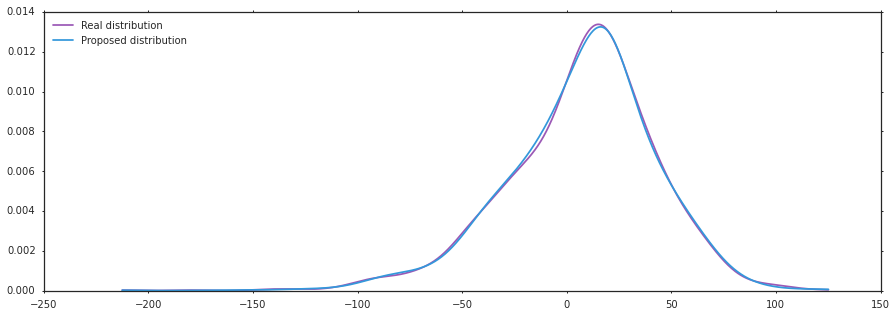

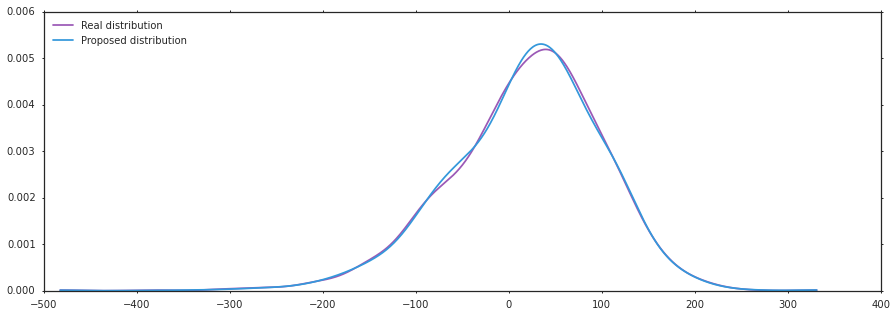

In [42]:
factorsReturnsGMMSamples = sample_MVGMM(model, 100000)
r0, n0 = plotDistributions(factorsReturns[0], factorsReturnsGMMSamples[0])
r1, n1 = plotDistributions(factorsReturns[1], factorsReturnsGMMSamples[1])
r2, n2 = plotDistributions(factorsReturns[2], factorsReturnsGMMSamples[2])
r3, n3 = plotDistributions(factorsReturns[3], factorsReturnsGMMSamples[3])

#print(fit_and_sample_GMM(factorsReturns.T, 100).T[0])
#_, _= plotDistributions(factorsReturns[3], fit_and_sample_GMM(factorsReturns.T, 100000).T[3])

<div class="alert alert-success">
Now the proposed distribution is much more similar to the real one (confirmed also by the KL divergence here below) and we expect better results on the simulation.
</div>

In [43]:
pdfs = [[r0, n0],[r1, n1],[r2, n2],[r3, n3]]
for i in range(len(pdfs)):
    print(entropy(pk=pdfs[i][0], qk=pdfs[i][1]))

0.000591418030543
0.00172914635281
0.000924874100338
0.000573380296611


In [52]:
def simulateTrialReturns_GMM(numTrials, model, weights):
    trialReturns = []
    weights=np.array(weights)
    trialFactorReturns = np.array(sample_MVGMM(model, numTrials)).T
    print(trialFactorReturns.shape)
    trialFeatures = np.apply_along_axis(featurize, axis=1, arr=trialFactorReturns)
    trialFeatures = np.insert(arr=trialFeatures, obj=0, values=1, axis=1)
    tmp = weights.dot(trialFeatures.T).sum(axis=0).tolist()
    return tmp

In [53]:
rawStocks = read_stocks(35, stock_folder)
stocks = preprocess_stocks(rawStocks)
stocksReturns = compute_stocks_returns(stocks)
weights = compute_weights(stocksReturns, factorsReturns)

parallelism = 12
numTrials = 250000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)

trials = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns_GMM(
                    max(int(numTrials/parallelism), 1), 
                    model,
                    weights
                ))
trials.cache()

valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)

print("Value at Risk(VaR) 5%:", valueAtRisk)
print("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk)
print("Kupiec test p-value: " , kupiecTestPValue(stocksReturns, valueAtRisk, 0.05))

Initial number of stocks:  35
Number of used stocks...:  28

Value at Risk(VaR) 5%: -21.953984311047776
Conditional Value at Risk(CVaR) 5%: -32.42997485509268
num failures: 88
Kupiec test p-value:  0.00483662649563


In [188]:
varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
print("VaR confidence interval: " , varConfidenceInterval)

cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)
print("CVaR confidence interval: " , cvarConfidenceInterval)

VaR confidence interval:  (-21.082918069799543, -21.09173836562229)
CVaR confidence interval:  (-32.165923186871886, -32.36460109141004)


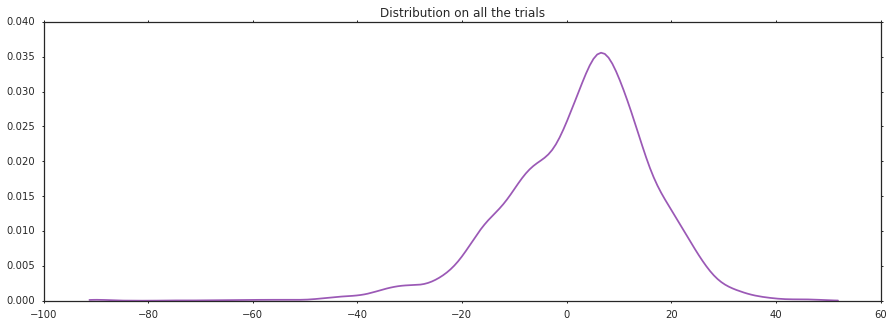

In [56]:
plotDistribution(trials.take(10000), title='Distribution on all the trials')

<div class="alert alert-success">
This is quite strange! Even though the distribution is way better than before, still the result is not so good and <b>the model cannot be validated</b>.

<br>

<table align="center">
  <tr>
    <th></th>
    <th>Multivariate Gaussian Model</th>
    <th>Mixture Gaussian Model</th>
  </tr>
  <tr>
    <td><b>VaR 5%</b></td>
    <td align="center" valign="middle">-20.03</td>
    <td align="center" valign="middle">-21.95</td>
  </tr>
  <tr>
    <td><b>Failures</b></td>
    <td>112</td>
    <td>88</td>
  </tr>
  <tr>
    <td><b>Kupiec Test</b></td>
    <td>~4e-8</td>
    <td>~4e-3</td>
  </tr>
</table> 
<br>
Nevertheless, this is encouraging: failures are reduced and test is higher than before.
<br><br>
On the other hand, though, this has driven us to the <b>hypothesis</b> we have done in the beginning of the notebook: we cannot expect to be able to characterize the whole <b>finantial market</b> basing on <b>only four factors</b>, no matter how well these are modeled. 
</div>

<div class="alert alert-success">
<h1>More factors!</h1>
<br>
Guided by these results, we have chosen to increase the number of factors using data coming from the <b>Federal Reserve Economic Data</b>.
</div>

In [54]:
def readFredHistory(fname):
    def process_line(line):
        cols = line.split(',')
        date = datetime.strptime(cols[0], "%Y-%m-%d")
        value = float(cols[1])#Close price
        return (date, value)
    
    with open(fname) as f:
        content_w_header = f.readlines()
        # remove the first line 
        # and reverse lines to sort the data by date, in ascending order
        content = content_w_header[1: len(content_w_header)]
        data = list(map(process_line , content))
        data.sort(key=lambda x:x[0])
        return data

In [55]:
factor1_files = ['crudeoil.tsv', 'us30yeartreasurybonds.tsv']
factor1_files = map(lambda fn: factors_folder + fn, factor1_files)
factors1 = [readInvestingDotComHistory(f) for f in factor1_files]

factor2_files = ['GSPC.csv', 'IXIC.csv', 'VXX.csv']
factor2_files = map(lambda fn: factors_folder + fn, factor2_files)
factors2 = [readYahooHistory(f) for f in factor2_files]

# Exchange rate USD/EU, China/USD, USD/UK, volatility, gold, inflation rate 10 y USA, Dow Jones Industrial Average
factor3_files = ['OVXCLS.csv','DEXUSEU.csv', 'DEXCHUS.csv', 'DEXUSUK.csv',  \
                 'GOLDAMGBD228NLBM.csv' , 'T10YIE.csv', 'DJIA.csv']
factor3_files = map(lambda fn: factors_folder + fn, factor3_files)
factors3 = [readFredHistory(f) for f in factor3_files]

In [56]:
df = [None for i in range(0, 8)]
df[0] = pd.DataFrame(factors2[2], columns=['Date','VXX'])
df[1] = pd.DataFrame(factors3[0], columns=['Date','OVXCLS'])
df[2] = pd.DataFrame(factors3[1], columns=['Date','DEXUSEU'])
df[3] = pd.DataFrame(factors3[2], columns=['Date','DEXCHUS'])
df[4] = pd.DataFrame(factors3[3], columns=['Date','DEXUSUK'])
df[5] = pd.DataFrame(factors3[4], columns=['Date','GOLDAMGBD228NLBM'])
df[6] = pd.DataFrame(factors3[5], columns=['Date','T10YIE'])
df[7] = pd.DataFrame(factors3[6], columns=['Date','DJIA'])
tmp = df[0]
for i in range(len(df)-1):
    tmp = tmp.merge(df[i+1], on=['Date'], how='inner')
df = tmp
df = df.set_index('Date')
df.index = df.index.to_datetime()

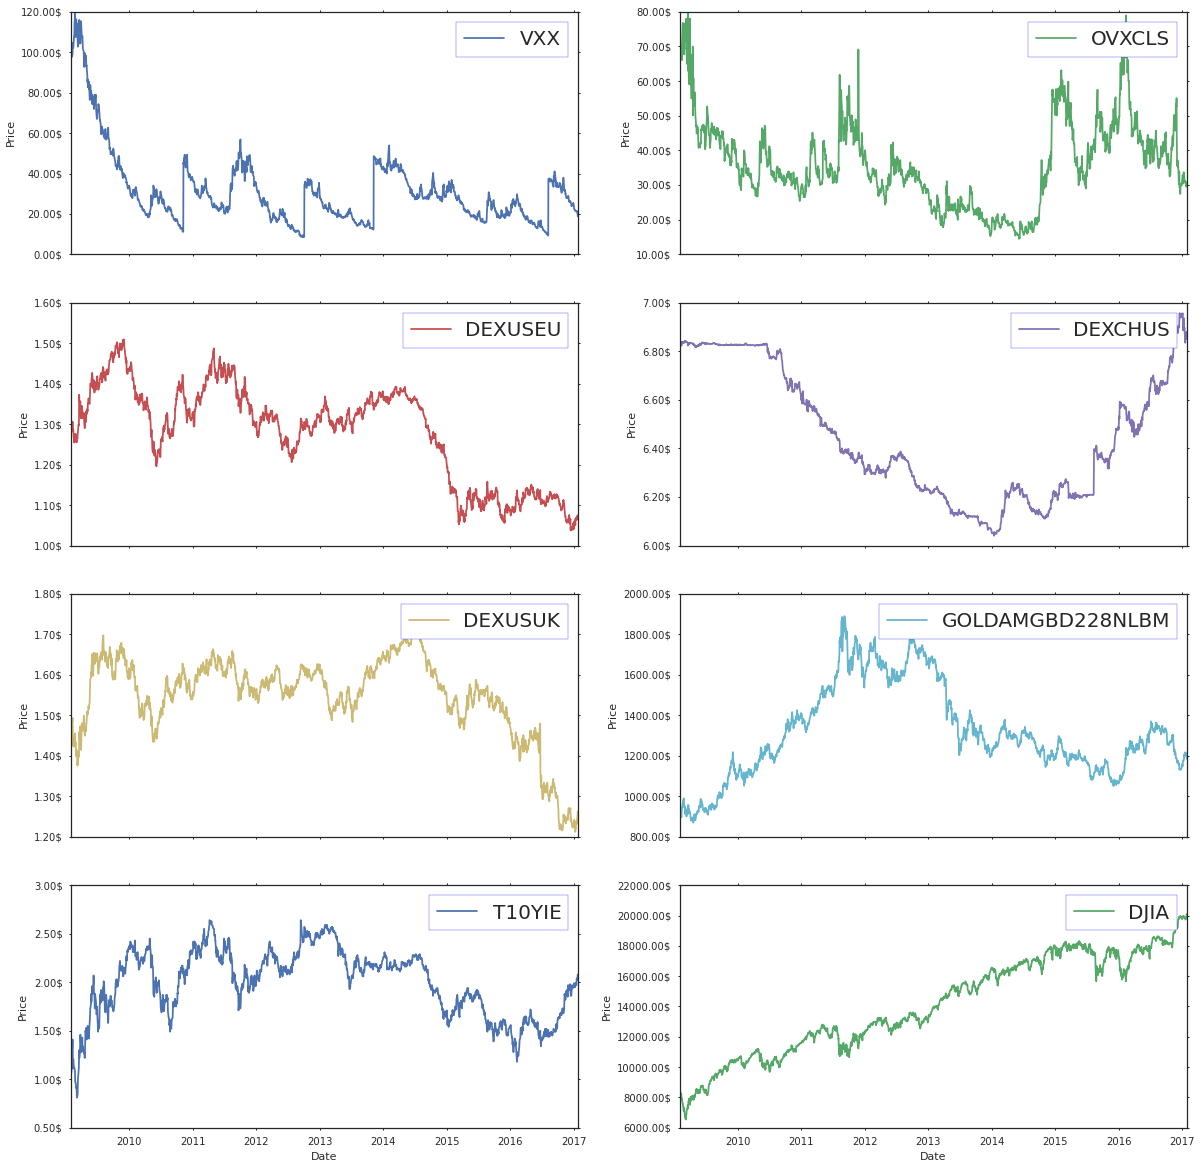

In [193]:
sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]

plot_cols = ['VXX', 'OVXCLS','DEXUSEU', 'DEXCHUS', 'DEXUSUK',  \
                 'GOLDAMGBD228NLBM' , 'T10YIE', 'DJIA']

fig, axes = plt.subplots(4,2, figsize=(20,20), sharex=True)
df[plot_cols].plot(subplots=True, ax=axes)

for axs, col in zip(axes, plot_cols):
    for ax in axs:
    
        ax.set_ylabel('Price')
        ax.set_xlabel('Date')
    
        ax.legend(fontsize=20, frameon=True).get_frame().set_edgecolor('blue')  
        
        yticks = ax.get_yticks()
        ax.set_yticklabels(['{:3.2f}$'.format(x) for x in yticks]);

<div class="alert alert-success">
Let's do some comments on these additional factors.

<br>
<h3>Volatility Analysis (VXX) </h3>
<br>
<b>Volatility</b> is a statistical measure of the dispersion of returns for a given security or market index. Commonly, the higher the volatility, the riskier the market. A variable in option pricing formulas showing the extent to which the return of the underlying asset will fluctuate between now and the option's expiration. Volatility, as expressed as a percentage coefficient within option-pricing formulas, arises from daily trading activities. How volatility is measured will affect the value of the coefficient used.
For the most part VXX trades like a stock. It can be bought, sold, or sold short anytime the market is open, including pre-market and after-market time periods. With an average daily volume of 75 million shares its liquidity is excellent and the bid/ask spreads are a penny.
Unlike stocks, owning VXX does not give you a share of a corporation. There are no sales, no quarterly reports, no profit/loss, no PE ratio, and no prospect of ever getting dividends. 
Ideally VXX would track the CBOE’s VIX index—the market’s de facto volatility indicator.  However since there are no investments available that directly track the VIX Barclays chose to track the next best choice: VIX futures. Most people invest in VXX as a contrarian investment, expecting it to go up when the equities market goes down. 
The value of VXX is set by the market. Every day the index specifies a new mix of VIX futures in that portfolio. 

<br>
<h3>Exchange rate Analysis</h3>
<br>
The exchange rate plays an important role in a country’s trade performance. Whether determined by exogenous shocks or by policy, the relative valuations of currencies and their volatility often have important repercussions on international trade, the balance of payments and overall economic performance. The first aspect of the relationship between exchange rates and trade relates to exchange rate volatility. The basic argument for which an increase in exchange rate volatility would result in lower international trade is that there are risks and transaction costs associated with variability in
the exchange rate, and these reduce the incentives to trade [3].


<br>
<h3>Dow Jones Industrial Average (DJIA)</h3>
<br>
It is an index that shows how 30 large publicly owned companies based in the United States have traded during a standard trading session in the stock market. The average is price-weighted, and to compensate for the effects of stock splits and other adjustments, it is currently a scaled average.


<br>
<h3>Gold</h3>
<br>
Gold is the most important store of value today and the most important components of the global economy since 1945. Gold's value remains fairly constant or increases overtime, it is hence used as an ideal hedge against inflation. People invest in gold because despite high inflation, it's value does not depreciate. Gold is also a safe haven asset. Increasing gold prices are a traditional indicator of a recession or a downturn in an economy. People run to the safety of gold when they think the value of other investments may go down in the future. Indians traditionally hold gold for the same reason, holding savings in gold immunes people from depreciation in the value of money which they can later use to pay for health care etc. 

<br>
<h3>Inflation Analysis</h3>
<br>
Inflation is the rate at which the general level of prices for goods and services is rising and, consequently, the purchasing power of currency is falling. Central banks attempt to limit inflation, and avoid deflation, in order to keep the economy running smoothly.
Central banks have tried to learn from such episodes, using monetary policy tools to keep inflation in check. Since the 2008 financial crisis, the U.S. Federal Reserve has kept interest rates near zero and pursued a bond-buying program – now discontinued – known as quantitative easing. Some critics of the program alleged it would cause a spike in inflation in the U.S. dollar, but inflation peaked in 2007 and declined steadily over the next eight years. There are many, complex reasons why QE didn't lead to inflation or hyperinflation, though the simplest explanation is that the recession was a strong deflationary environment, and quantitative easing ameliorated its effects.

</div>

In [58]:
start = datetime(year=2009, month=1, day=23)
end = datetime(year=2014, month=1, day=23)

# merge two factors, trim each factor into a time region
# and fill up the missing values
allfactors = factors1 + factors2 + factors3
factors = list(map(lambda fact: \
                fillInHistory(
                trimToRegion(fact, start, end), 
                start, end), 
            allfactors))

factorsReturns = list(map(twoWeekReturns, factors))

In [59]:
def get_distribution_from_samples(samples):
    vmin = min(samples)
    vmax = max(samples)
    stddev = np.std(samples)
    
    domain = np.arange(vmin, vmax, (vmax-vmin)/250)
    bandwidth = 1.06 * stddev * pow(len(samples), -.2)
    
    kde = KDEUnivariate(samples)
    kde.fit(bw=bandwidth)
    density = kde.evaluate(domain)
    
    return (domain, density)

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


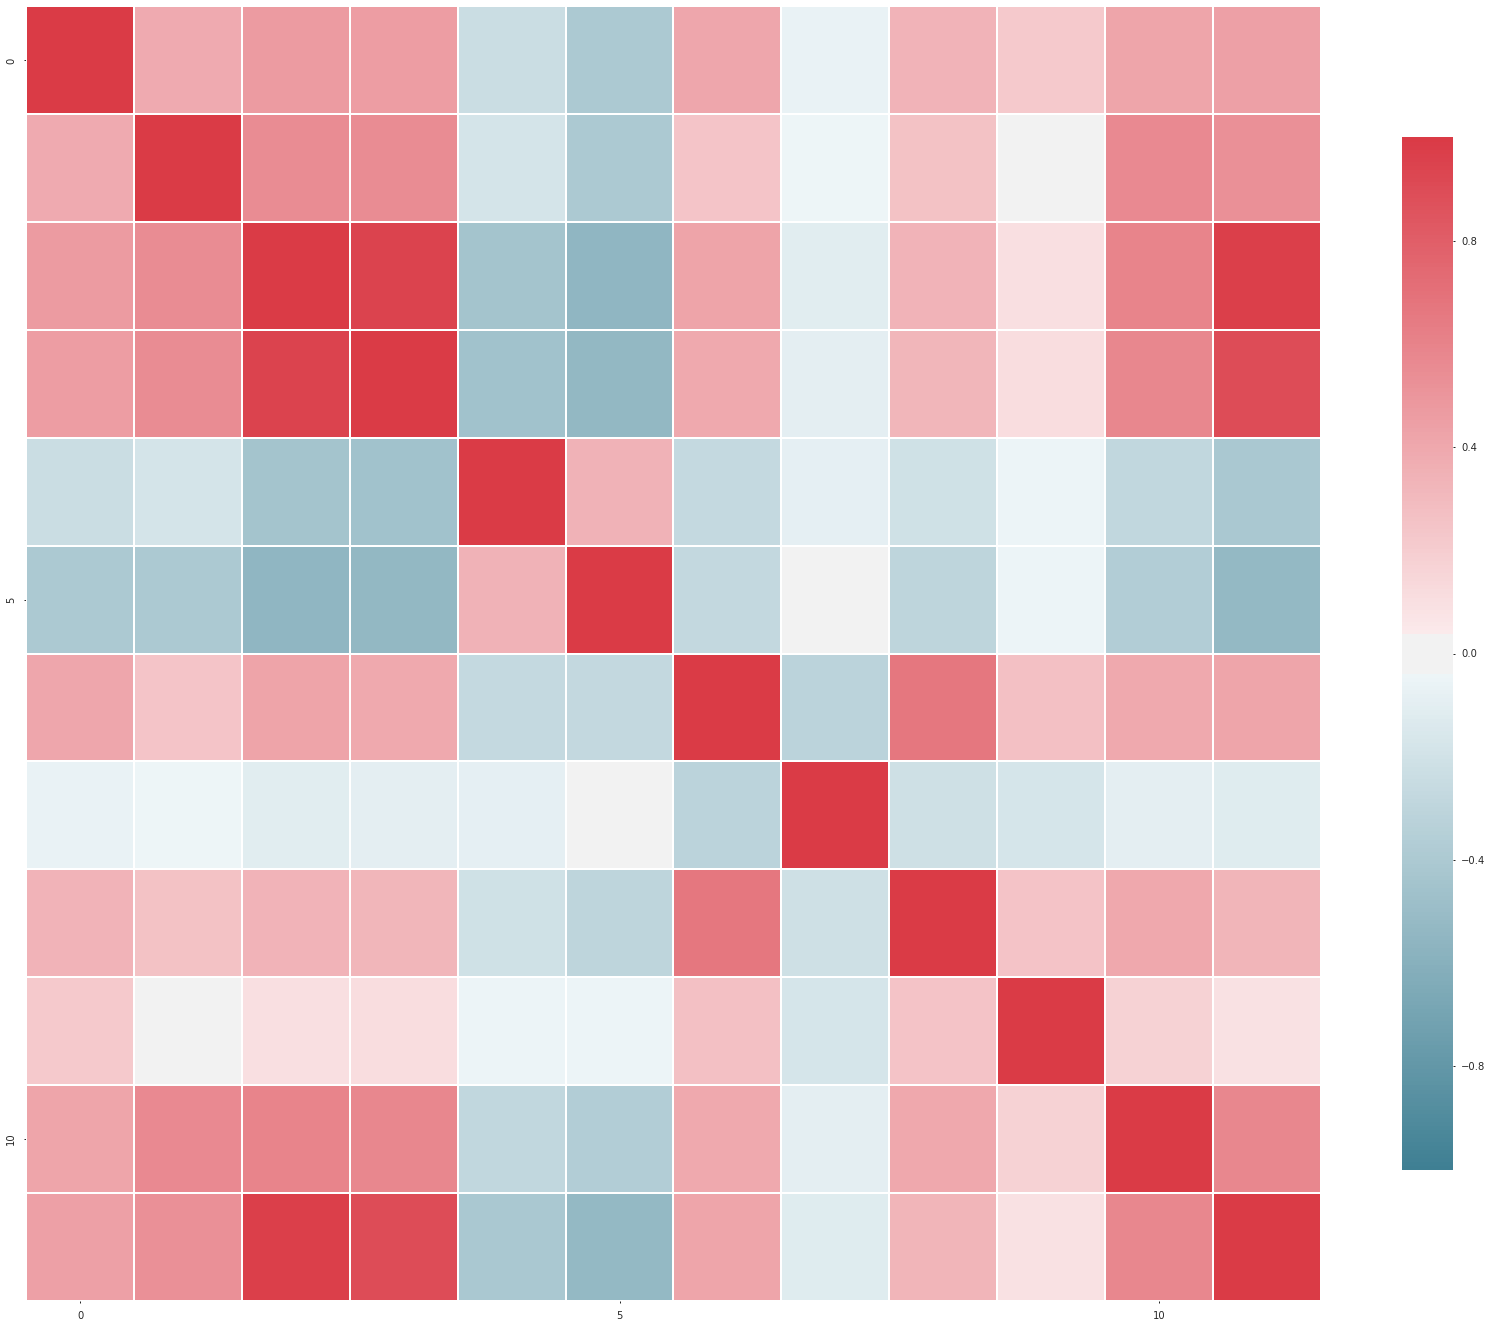

In [101]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(len(weights),len(weights[0])))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation,  cmap=cmap, vmax=1.0,square=True, xticklabels=5, \
            yticklabels=5,linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

<div class="alert alert-success">
Ideally we would like to have white cells (0 correlation between factors) outside the diagonal but unfortunately some of them are quite correlated. Interestingly enough, most of the cells are red, meaning that most of the factors move in the same direction.  
</div>

<div class="alert alert-success">
<h2>Multivariate distribution</h2>
<br>
Let's start doing the analysis with the simple multivariate Gaussian. Since now we have 12 factors, using only 35 instruments we end up in a fat weight matrix, which is difficult to estimate. For this reason, we moved to 200 instruments to start.
</div>

In [75]:
rawStocks = read_stocks(200, stock_folder)
stocks = preprocess_stocks(rawStocks)
stocksReturns = compute_stocks_returns(stocks)
weights = compute_weights(stocksReturns, factorsReturns)

Initial number of stocks:  200
Number of used stocks...:  134



In [61]:
factorCov = np.cov(factorsReturns)
factorMeans = [sum(factorReturns)/len(factorReturns) for factorReturns in factorsReturns]

factorMat = transpose(matrix=factorsReturns)
factorFeatures = list(map(lambda factor:featurize(factor), factorMat))
factor_columns = np.array(factorFeatures)
factor_columns = sm.add_constant(factor_columns, prepend=True)
weights = [estimateParams(stockReturns, factor_columns) for stockReturns in stocksReturns]

print("weights:", np.array(weights).shape)
print(factorCov.shape)
print(np.array(factorMeans).shape)

weights: (134, 37)
(12, 12)
(12,)


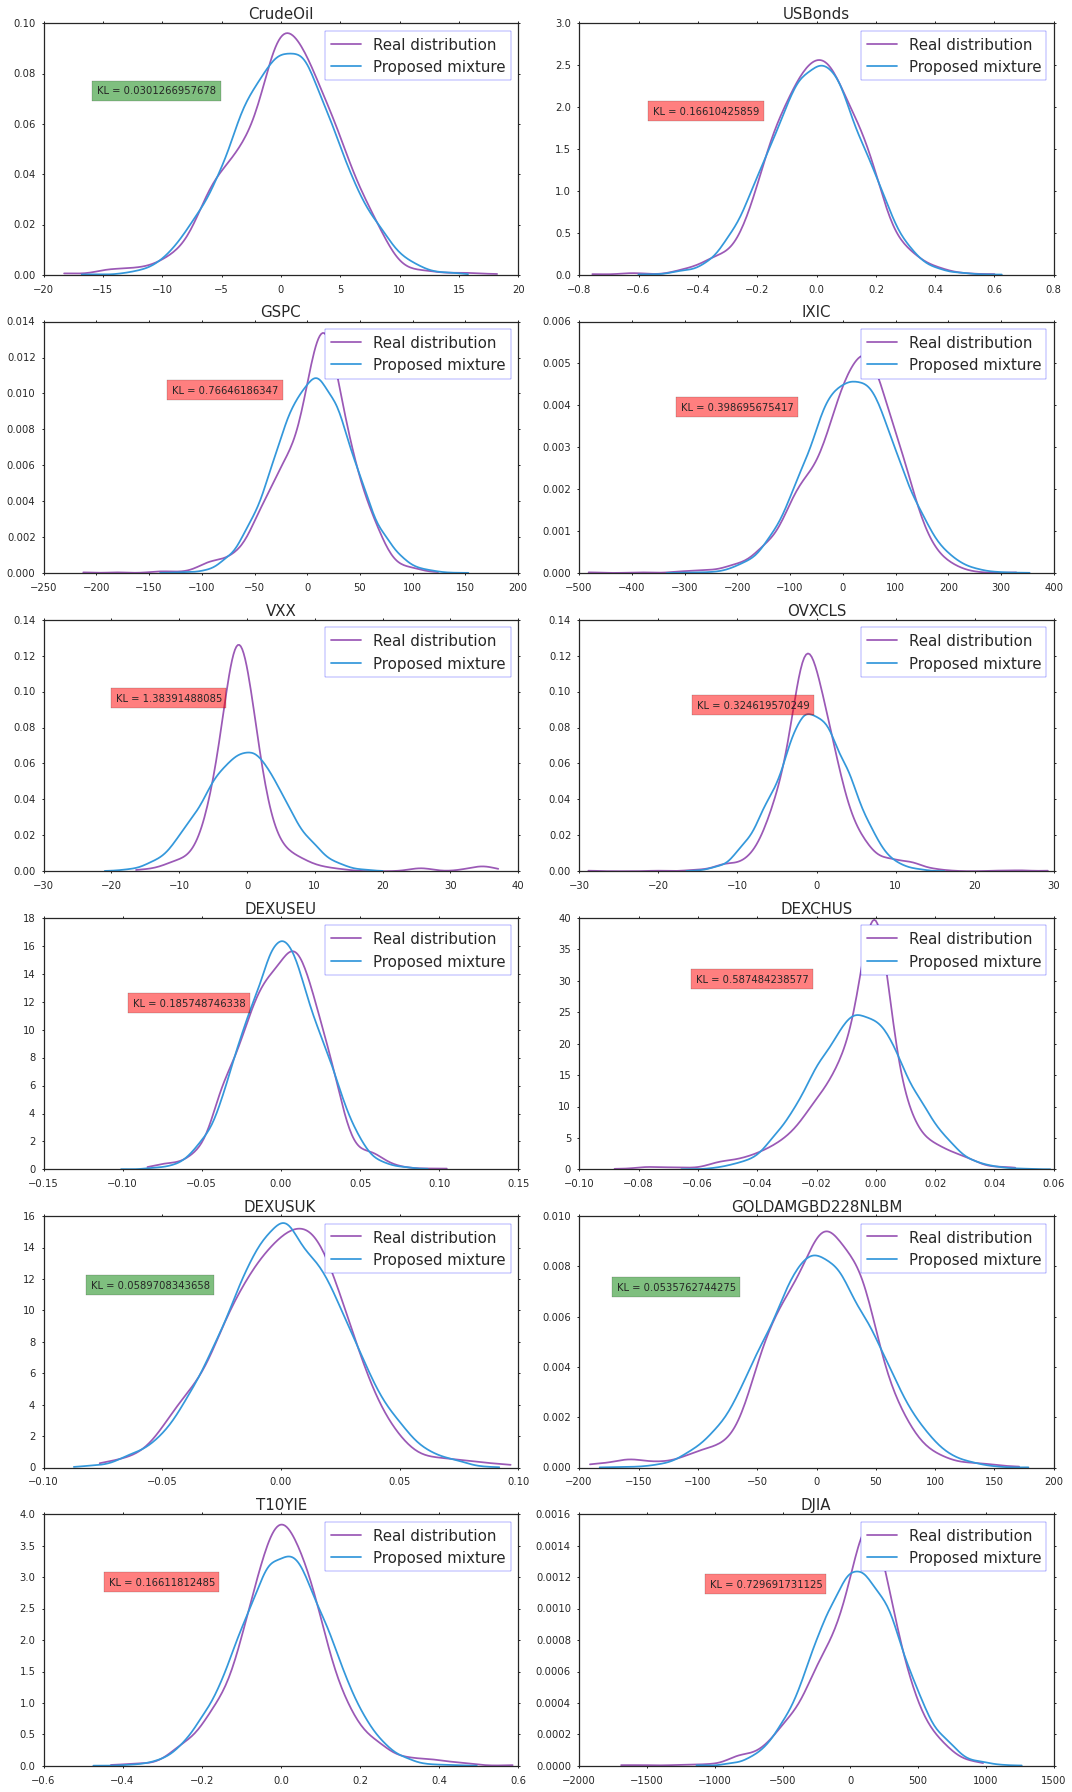

In [115]:
samples = np.random.multivariate_normal(factorMeans, factorCov, size=10000)
factorReturnNormalSamples = []
for i in range(12):
    factorReturnNormalSamples.append(samples[:,i])

factor_names = ['CrudeOil', 'USBonds', 'GSPC', 'IXIC', 'VXX', 'OVXCLS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK',  \
                'GOLDAMGBD228NLBM', 'T10YIE', 'DJIA']
plt.figure(figsize=(15, 25))
for i in range(len(factorsReturns)):
    plt.subplot(6, 2, i+1)
    x, yp = get_distribution_from_samples(factorsReturns[i])
    plt.plot(x, yp, label='Real distribution')
    x, yq = get_distribution_from_samples(factorReturnNormalSamples[i])
    kl = entropy(pk=yp[:249], qk=yq[:249])
    ax = plt.plot(x, yq, label='Proposed mixture')
    
    kl_string = 'KL = ' + str(kl)
    if kl <= 0.1:
        box = {'facecolor':'green', 'alpha':0.5, 'pad':10}
    else:
        box = {'facecolor':'red', 'alpha':0.5, 'pad':10}
    
    plt.text(x[10], np.max(yp)*0.75, kl_string, style='normal', bbox=box)
    plt.legend(fontsize=15, frameon=True).get_frame().set_edgecolor('blue')  
    plt.title(factor_names[i], fontsize=15)
plt.tight_layout()

<div class="alert alert-success">
Note that to have a good estimation of a Gaussian in 12 dimensions, the number of data we would have to sample should be higher, but unfortunately the kernel crashed with more than 10000 samples.
</div>

In [68]:
parallelism = 12
numTrials = 5000000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)

trials = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns(
                    max(int(numTrials/parallelism), 1), 
                    factorMeans,
                    factorCov,
                    weights
                ))
trials.cache()

valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)

print("Value at Risk(VaR) 5%:", valueAtRisk)
print("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk)
print("Kupiec test p-value: " , kupiecTestPValue(stocksReturns, valueAtRisk, 0.05))

Value at Risk(VaR) 5%: -114.77185654436752
Conditional Value at Risk(CVaR) 5%: -145.84317296717245
num failures: 53
Kupiec test p-value:  0.122407876845


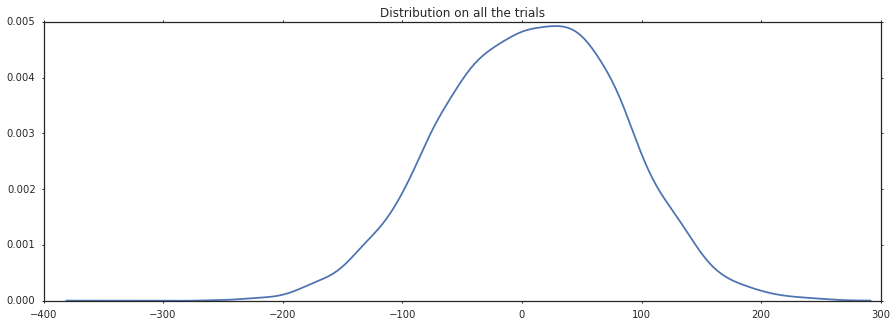

In [70]:
plotDistribution(trials.take(10000), title='Distribution on all the trials')

In [65]:
varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
print("VaR confidence interval: " , varConfidenceInterval)

cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)
print("CVaR confidence interval: " , cvarConfidenceInterval)

VaR confidence interval:  (-114.53737795744135, -114.99454119551355)
CVaR confidence interval:  (-148.80158089532006, -146.78590810736137)


<div class="alert alert-success">
Finally, <b>we did it</b>! The number of failures has drastically reduced and the model is accepted! 
</div>

<div class="alert alert-success">
<h2>Mixture of Multivariate Gaussian Distributions</h2>
<br>
Galvanized by this encouraging result, we moved to modeling factors using a <b>Mixture of Multivariate Gaussian Distributions Model</b>.
</div>

In [66]:
factorsReturns = np.array(factorsReturns)
model = fit_MVGMM(factorsReturns.T, components=200)

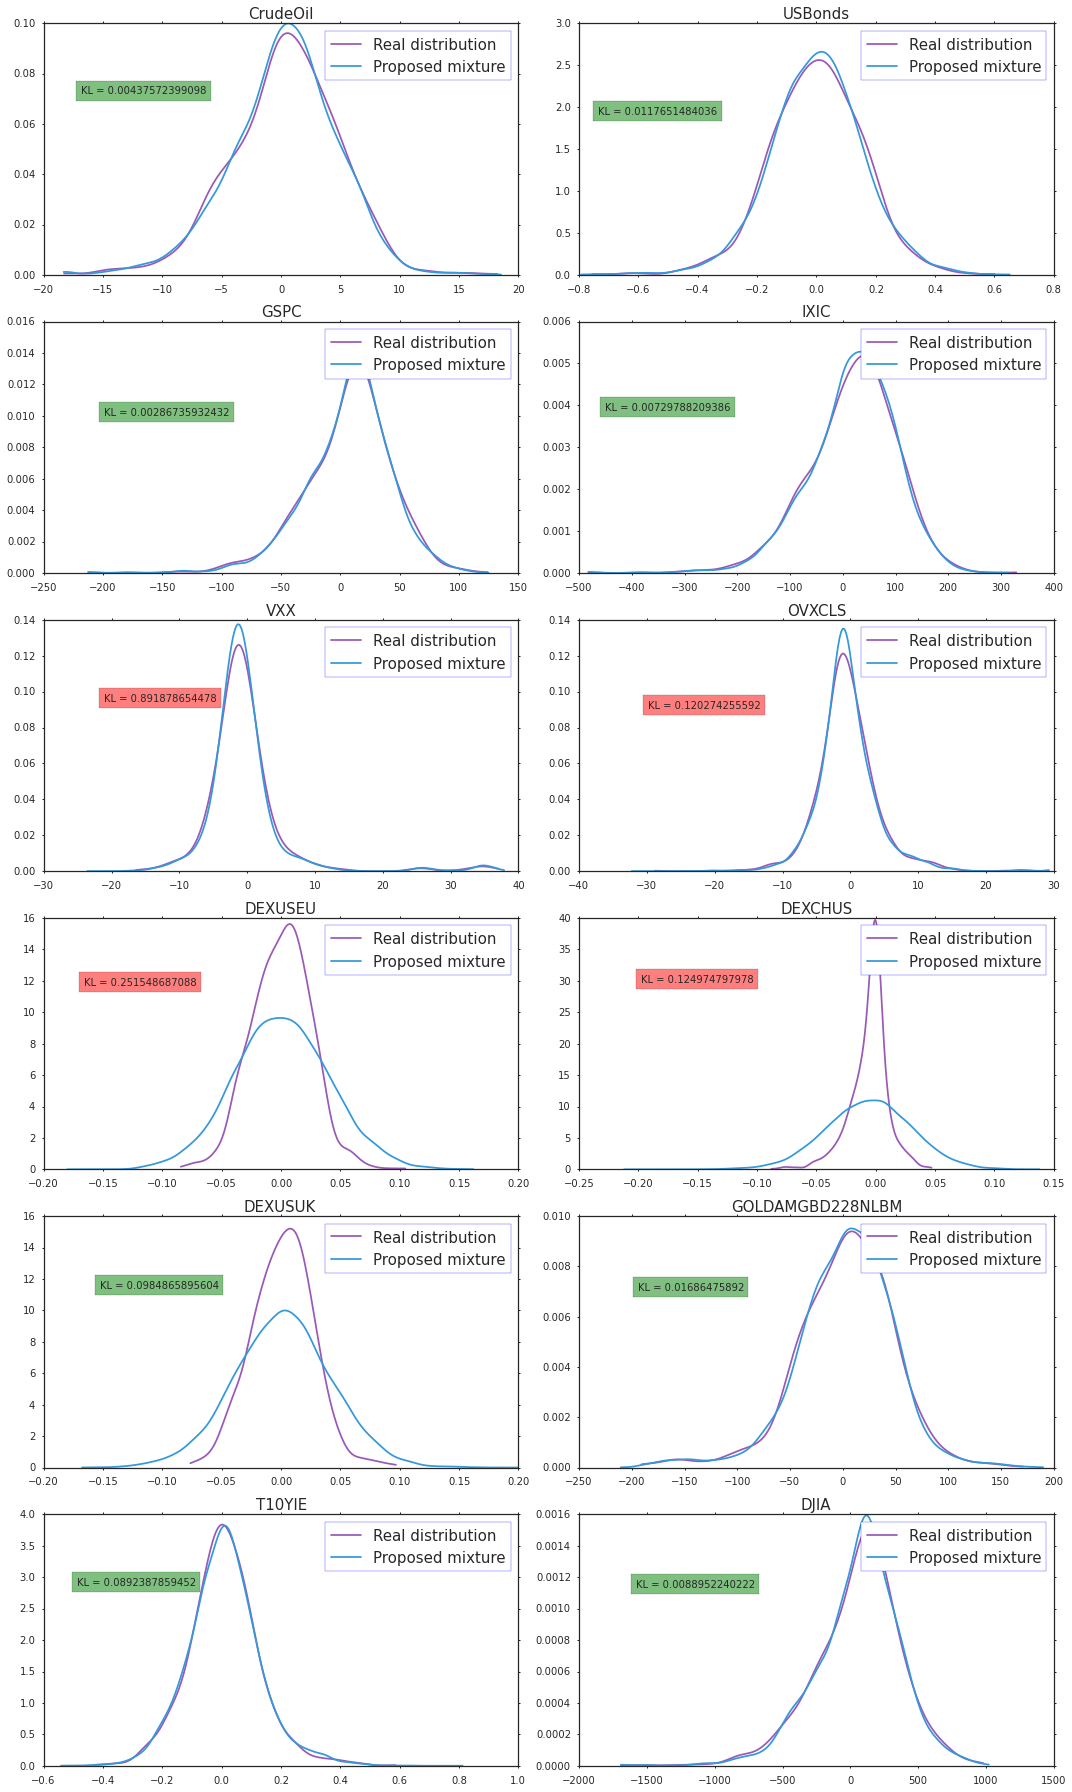

In [112]:
factorsReturnsGMMSamples = sample_MVGMM(model, 10000)
factor_names = ['CrudeOil', 'USBonds', 'GSPC', 'IXIC', 'VXX', 'OVXCLS', 'DEXUSEU', 'DEXCHUS', 'DEXUSUK',  \
                'GOLDAMGBD228NLBM', 'T10YIE', 'DJIA']
plt.figure(figsize=(15, 25))
for i in range(len(factorsReturns)):
    plt.subplot(6, 2, i+1)
    x, yp = get_distribution_from_samples(factorsReturns[i])
    plt.plot(x, yp, label='Real distribution')
    x, yq = get_distribution_from_samples(factorsReturnsGMMSamples[i])
    kl = entropy(pk=yp[:249], qk=yq[:249])
    ax = plt.plot(x, yq, label='Proposed mixture')
    
    kl_string = 'KL = ' + str(kl)
    if kl <= 0.1:
        box = {'facecolor':'green', 'alpha':0.5, 'pad':10}
    else:
        box = {'facecolor':'red', 'alpha':0.5, 'pad':10}
    
    plt.text(x[10], np.max(yp)*0.75, kl_string, style='normal', bbox=box)
    
    plt.legend(fontsize=15, frameon=True).get_frame().set_edgecolor('blue')  
    plt.title(factor_names[i], fontsize=15)
plt.tight_layout()

<div class="alert alert-success">
The proposed distribution now follows the real one with more accuracy as KL confirms.
</div>

<div class="alert alert-success">
Let's simulate with 1000 stocks!
</div>

In [73]:
rawStocks = read_stocks(1000, stock_folder)

Initial number of stocks:  1000
Number of used stocks...:  714



In [74]:
stocks = preprocess_stocks(rawStocks)
stocksReturns = compute_stocks_returns(stocks)
weights = compute_weights(stocksReturns, factorsReturns)
factorsReturns = np.array(factorsReturns)
model = fit_MVGMM(factorsReturns.T, components=300)
parallelism = 12
numTrials = 1000000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)

trials = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns_GMM(
                    max(int(numTrials/parallelism), 1), 
                    model,
                    weights
                ))
trials.cache()

valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)

print("Value at Risk(VaR) 5%:", valueAtRisk)
print("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk)
print("Kupiec test p-value: " , kupiecTestPValue(stocksReturns, valueAtRisk, 0.05))

Value at Risk(VaR) 5%: -587.9744774223269
Conditional Value at Risk(CVaR) 5%: -855.2003468351426
num failures: 74
Kupiec test p-value:  0.248384039058


<div class="alert alert-success">
This is interesting! Even with 1000 stocks the model performs way better than before. 
<br><br>
As a final test, we attempt to use all the available stocks.
</div>

In [77]:
rawStocks = read_stocks(2710, stock_folder)
stocks = preprocess_stocks(rawStocks)
stocksReturns = compute_stocks_returns(stocks)
weights = compute_weights(stocksReturns, factorsReturns)
factorsReturns = np.array(factorsReturns)
model = fit_MVGMM(factorsReturns.T, components=300)
parallelism = 12
numTrials = 10000000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)

trials = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns_GMM(
                    max(int(numTrials/parallelism), 1), 
                    model,
                    weights
                ))
trials.cache()

valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)

print("Value at Risk(VaR) 5%:", valueAtRisk)
print("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk)
print("Kupiec test p-value: " , kupiecTestPValue(stocksReturns, valueAtRisk, 0.05))

Initial number of stocks:  2710
Number of used stocks...:  1911

Value at Risk(VaR) 5%: -1683.546397938518
Conditional Value at Risk(CVaR) 5%: -2409.5994276379383
num failures: 65
Kupiec test p-value:  0.974586731683


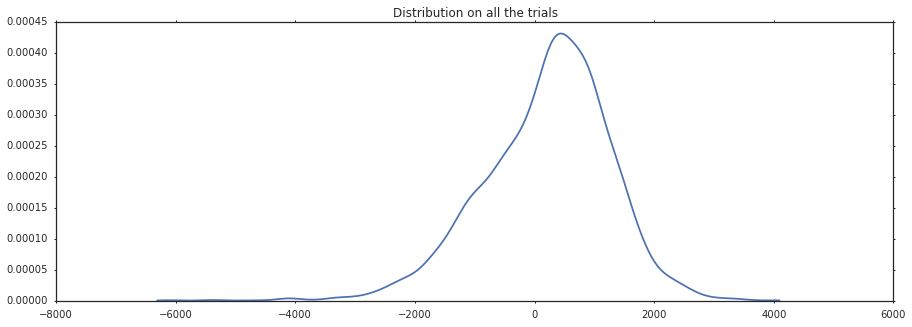

In [78]:
plotDistribution(trials.take(10000), title='Distribution on all the trials')

<div class="alert alert-success">
<h1><a href='https://media.giphy.com/media/8fen5LSZcHQ5O/giphy.gif'>EXCELLENT!</a></h1>
<br>
With a portfolio of all the stocks available (1911), this model performs very well! Despite the high volume of stocks we're working on, the VaR 5% is acceptable, the number of failures is very small and the model is perfectly acceptable.
</div>

![alt text](https://i.ytimg.com/vi/stard6Tazkg/maxresdefault.jpg)

# 6. Summary
In this lecture, we studied the Monte Carlo Simulation method and its application to estimate financial risk. To apply it, first, we needed to define the relationship between market factors and the instruments' returns. In such step, you must define the model which maps the market factors' values to the instruments' values: in our use case, we used a linear regression function for building our model. Next, we also had to find the parameters of our model, which are the weights of the factors we considered. Then, we had to study the distribution of each market factor. A good way to do that is using Kernel density estimation to smooth the distribution and plot it. Depending on the shape of each figure, we had to guess the best fit distribution for each factor: in our use case, we used a very simple approach, and decided that our smoothed distributions all looked normal distributions. 

Then, the idea of Monte Carlo simulation was to generate many possible values for each factor and calculate the corresponding outcomes by a well-defined model in each trial. After many trials, we were able to calculate VaR from the sequences of outcome's values. When the number of trials is large enough, the VaR converges to reasonable values, that we could validate using well-known statistical hypothesis. 

# References
- The example in section 2 is inspired from [this article](http://www.solver.com/monte-carlo-simulation-example).
- [Backtesting Value-at-Risk models](https://aaltodoc.aalto.fi/bitstream/handle/123456789/181/hse_ethesis_12049.pdf?sequence=1) (Kansantaloustiede, 2009) - (A good reference to study Backtesting).


``[1]`` https://www.macroaxis.com/invest/market/%5EIXIC--compareProfile--%5EGSPC

``[2]`` https://seekingalpha.com/article/3271415-is-crude-oil-correlated-to-the-10-year-u-s-treasury-note

``[3]`` Alessandro Nicita,  _EXCHANGE RATES, INTERNATIONAL TRADE AND TRADE POLICIES_, 2013

``[4]`` https://www.msn.com/en-in/money/topstories/10-most-expensive-stocks-in-the-world/ss-BB91I9n#image=10
